# Text Classification Assignment

In this assignment we will address a text classification problem: we will try to predict "Fake News" among a dataset of news reports.

To that end we will implement our own Naïve Bayes model. In addition, we will use some more sophisticated models (already seen in class), which are included in sklearn.

Before applying any algorithm, we have to create the data structrues needed (document-term matrix) and we have to process the textual data (tokenization, stemming, ...).

To improve the performance of the classifiers, we will also apply some more advanced NLP methodologies, such as: different weighting schemas, using n-grams.

In [3]:
# Needed Libraries
# Matplotlib conf
import matplotlib.pyplot as plt
%matplotlib inline
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':40,
         'ytick.labelsize': 40
}
plt.rcParams.update(params)
# Seaborn conf
import seaborn as sns
sns.set(style='darkgrid')
#plt.rcParams['figure.figsize'] = 10,5
# import gtch
sns.set_palette(sns.color_palette("Blues"))

import sys

import pandas
import numpy as np
import operator

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2

from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix




## Dataset Loading

Making use of pandas and sklearn, we load and prepare the dataset for the training step

In [4]:
# Dataset Loading
training_set = pandas.read_csv("./fake_or_real_news_training.csv", quotechar='"', header=0, sep=",")
test_set = pandas.read_csv("./fake_or_real_news_test.csv", quotechar='"', header=0, sep=",")

In [5]:
# You do not have this! These are the labels for the test set that I have used to evaluate your models.
# I loaded it to allow the evaluation of my models in this notebook
test_labels = pandas.read_csv("./fake_or_real_news_gs.csv", quotechar='"', header=0, sep=",")["label"]

In [6]:
training_set.head(20)

,ID,title,text,label,X1,X2
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,NaN,NaN
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,NaN,NaN
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,NaN,NaN
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,NaN,NaN
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,NaN,NaN
5,6903,"Tehran, USA","\nI’m not an immigrant, but my grandparents ...",FAKE,NaN,NaN
6,7341,Girl Horrified At What She Watches Boyfriend D...,"Share This Baylee Luciani (left), Screenshot o...",FAKE,NaN,NaN
7,95,‘Britain’s Schindler’ Dies at 106,A Czech stockbroker who saved more than 650 Je...,REAL,NaN,NaN
8,4869,Fact check: Trump and Clinton at the 'commande...,Hillary Clinton and Donald Trump made some ina...,REAL,NaN,NaN
9,2909,Iran reportedly makes new push for uranium con...,Iranian negotiators reportedly have made a las...,REAL,NaN,NaN


In [7]:
test_set.head()

,ID,title,text
0,10498,September New Homes Sales Rise——-Back To 1992 ...,September New Homes Sales Rise Back To 1992 Le...
1,2439,Why The Obamacare Doomsday Cult Can't Admit It...,But when Congress debated and passed the Patie...
2,864,"Sanders, Cruz resist pressure after NY losses,...",The Bernie Sanders and Ted Cruz campaigns vowe...
3,4128,Surviving escaped prisoner likely fatigued and...,Police searching for the second of two escaped...
4,662,Clinton and Sanders neck and neck in Californi...,No matter who wins California's 475 delegates ...


In order to facilitate the later processing, we merge both datasets.

By inspecting the dataset, I have detected a problem in the training set

The separator for the fields is "," and the title field is not "escaped", which cause that titles with ',' are splited in two fields, causing a displacement of the whole row.

Sadly, this kind of problems is more usual than we would like. For that reason you should always inspect your dataset before start working with it.


In [8]:
rows_with_problems = training_set[training_set.X1.isnull() == False]
rows_with_problems

,ID,title,text,label,X1,X2
192,599,Election Day: No Legal Pot In Ohio,Democrats Lose In The South,Election Day: No Legal Pot In Ohio; Democrats ...,REAL,NaN
308,10194,Who rode it best? Jesse Jackson mounts up to f...,Leonardo DiCaprio to the rescue?,Who rode it best? Jesse Jackson mounts up to f...,FAKE,NaN
382,356,Black Hawk crashes off Florida,human remains found,(CNN) Thick fog forced authorities to suspend ...,REAL,NaN
660,2786,Afghanistan: 19 die in air attacks on hospital,U.S. investigating,(CNN) Aerial bombardments blew apart a Doctors...,REAL,NaN
889,3622,Al Qaeda rep says group directed Paris magazin...,US issues travel warning,A member of Al Qaeda's branch in Yemen said Fr...,REAL,NaN
911,7375,Shallow 5.4 magnitude earthquake rattles centr...,shakes buildings in Rome,00 UTC © USGS Map of the earthquake's epicent...,FAKE,NaN
1010,9097,ICE Agent Commits Suicide in NYC,Leaves Note Revealing Gov’t Plans to Round-up...,Email Print After writing a lengthy suicide no...,FAKE,NaN
1043,9203,Political Correctness for Yuengling Brewery,What About Our Opioid Epidemic?,We Are Change \n\nIn today’s political climate...,FAKE,NaN
1218,1602,Poll gives Biden edge over Clinton against GOP...,VP meets with Trumka,A new national poll shows Vice President Biden...,REAL,NaN
1438,4562,Russia begins airstrikes in Syria,U.S. warns of new concerns in conflict,Russian warplanes began airstrikes in Syria on...,REAL,NaN


Let's solve the problem by joining the title of the affected columns and replace the values

In [9]:
training_set.loc[training_set.X1.isnull() == False, 'title'] = rows_with_problems.title + rows_with_problems.text
training_set.loc[training_set.X1.isnull() == False, 'text'] = rows_with_problems.label
training_set.loc[training_set.X1.isnull() == False, 'label'] = rows_with_problems.X1

In [10]:
training_set[training_set.X1.isnull() == False]

,ID,title,text,label,X1,X2
192,599,Election Day: No Legal Pot In Ohio Democrats L...,Election Day: No Legal Pot In Ohio; Democrats ...,REAL,REAL,NaN
308,10194,Who rode it best? Jesse Jackson mounts up to f...,Who rode it best? Jesse Jackson mounts up to f...,FAKE,FAKE,NaN
382,356,Black Hawk crashes off Florida human remains f...,(CNN) Thick fog forced authorities to suspend ...,REAL,REAL,NaN
660,2786,Afghanistan: 19 die in air attacks on hospital...,(CNN) Aerial bombardments blew apart a Doctors...,REAL,REAL,NaN
889,3622,Al Qaeda rep says group directed Paris magazin...,A member of Al Qaeda's branch in Yemen said Fr...,REAL,REAL,NaN
911,7375,Shallow 5.4 magnitude earthquake rattles centr...,00 UTC © USGS Map of the earthquake's epicent...,FAKE,FAKE,NaN
1010,9097,ICE Agent Commits Suicide in NYC Leaves Note R...,Email Print After writing a lengthy suicide no...,FAKE,FAKE,NaN
1043,9203,Political Correctness for Yuengling Brewery Wh...,We Are Change \n\nIn today’s political climate...,FAKE,FAKE,NaN
1218,1602,Poll gives Biden edge over Clinton against GOP...,A new national poll shows Vice President Biden...,REAL,REAL,NaN
1438,4562,Russia begins airstrikes in Syria U.S. warns o...,Russian warplanes began airstrikes in Syria on...,REAL,REAL,NaN


There is still two rows with problems.

In [11]:
training_set[training_set.X2.isnull() == False]

,ID,title,text,label,X1,X2
2184,9,Planned Parenthood’s lobbying effort pay raise...,and the future Fed rates,PLANNED PARENTHOOD’S LOBBYING GETS AGGRESSIVE....,PLANNED PARENTHOOD’S LOBBYING GETS AGGRESSIVE....,REAL
3537,6268,Chart Of The Day: Since 2009—–Recovery For The...,Chart Of The Day: Since 2009 Recovery For The 5%,Stagnation for the 95%,Stagnation for the 95%,FAKE


Since they are only two, we can safely delete them.

In [12]:
training_set = training_set[training_set.X2.isnull() == True]

# Inspecting the data


**First we are going to inspect the distribution of the classes (FAKE and REAL) to see if they are unbalanced**

(array([0, 1]), <a list of 2 Text xticklabel objects>)

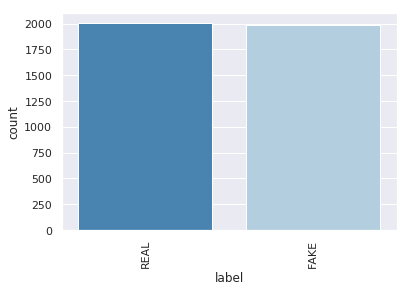

In [13]:
from collections import Counter
sns.countplot(training_set.label, order=[x for x, count in sorted(Counter(training_set.label).items(), key=lambda x: -x[1])], palette="Blues_r")
plt.xticks(rotation=90)

As seen in the figure, we have the same number of FAKE and REAL news, therefore we do not have to worry about inbalanced classes

**Let us now inspect the text of the news belongin to each class.**

In the following figure we plot the most common words in each class.

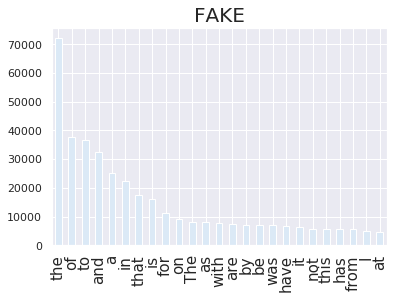

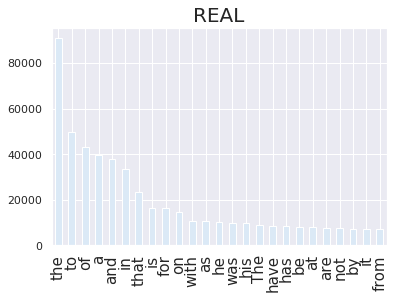

In [14]:
import pandas as pd
from matplotlib import interactive

df = pd.DataFrame({"text": training_set.text, "CLASS": training_set.label})
grouped = df.groupby(["CLASS"]).apply(lambda x: x["text"].sum())
grouped_df = pd.DataFrame({"CLASS": grouped.index, "text": grouped.values})

from nltk.tokenize import WhitespaceTokenizer
tokenizer = WhitespaceTokenizer()

for ii, text in enumerate(grouped_df.text):
    pd.DataFrame(tokenizer.tokenize(text)).apply(pd.value_counts).head(25).plot(kind="bar", legend=None)
    plt.title(grouped_df.CLASS[ii], fontsize=20)
    plt.xticks(fontsize=15)
    interactive(True)
    plt.show()

Well, this first inspection has been quite a disappointment.

By plotting the most repeated words in each class we expected to see the words "most representative" of each class. If they were different enough, this will indicate us that we can use them to easily identify real and fake news.

However, what we see is the same set of uninformative words for both classes. What we are seeing are mostly **stopwords** which are not related to the class and might affect the final classifier. It seems that we will have to remove them latter.

Another issue that we can detect with this inspection is that we have words like `The` and `the` which are the same but are considered as a different term because of the capitalization. It shows that we will have to **normalize** the words.

In addition, we find different forms of the same verb: `are`, `be`, `is`. If you remember for class we have two methodologies to extract the basic form of a word: **stemming and lemmatization**. Stemming will not resolve this problem. As seen in class it finds the basic forms (stems) by chunking the words. In contrast, by lemmatizing the words we will find the basic form of the words (`be` for the words `are`, `be` and `is`).
In any case, it may be worthy to try both approaches.

## Text Processing and Data Preparation


We will start with a basic Natural Language Pre-processing
 - Extract English Words
 - Lemmatize text to exclude repeated words with same root
 - Stem words to avoid over counting same meaning words
 - Removing stop words


In [15]:
dataset = pandas.concat([training_set,test_set], sort=True)

To encapsulate this process and facilitate its application, we create a function `process_text` which encloses all the text processing

In [16]:
from nltk.stem import *
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import re

def process_text(raw_text):
    letters_only = re.sub("[^a-zA-Z]", " ",raw_text) 
    words = letters_only.lower().split()
    
    stops = set(stopwords.words("english")) 
    not_stop_words = [w for w in words if not w in stops]
    
    wordnet_lemmatizer = WordNetLemmatizer()
    lemmatized = [wordnet_lemmatizer.lemmatize(word) for word in not_stop_words]
    
    stemmer = PorterStemmer()
    stemmed = [stemmer.stem(word) for word in lemmatized]
    
    return( " ".join( stemmed ))  

We now apply this function to the textual contents in the dataset: `text` and `title`.

Just in case we need the raw text later, we will create new columns to store the processed text.

In [17]:
dataset['clean_text'] = dataset['text'].apply(lambda x: process_text(x))
dataset['clean_title'] = dataset['title'].apply(lambda x: process_text(x))
dataset.head()

,ID,X1,X2,label,text,title,clean_text,clean_title
0,8476,NaN,NaN,FAKE,"Daniel Greenfield, a Shillman Journalism Fello...",You Can Smell Hillary’s Fear,daniel greenfield shillman journal fellow free...,smell hillari fear
1,10294,NaN,NaN,FAKE,Google Pinterest Digg Linkedin Reddit Stumbleu...,Watch The Exact Moment Paul Ryan Committed Pol...,googl pinterest digg linkedin reddit stumbleup...,watch exact moment paul ryan commit polit suic...
2,3608,NaN,NaN,REAL,U.S. Secretary of State John F. Kerry said Mon...,Kerry to go to Paris in gesture of sympathy,u secretari state john f kerri said monday sto...,kerri go pari gestur sympathi
3,10142,NaN,NaN,FAKE,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",Bernie supporters on Twitter erupt in anger ag...,kayde king kaydeek novemb lesson tonight dem l...,berni support twitter erupt anger dnc tri warn
4,875,NaN,NaN,REAL,It's primary day in New York and front-runners...,The Battle of New York: Why This Primary Matters,primari day new york front runner hillari clin...,battl new york primari matter


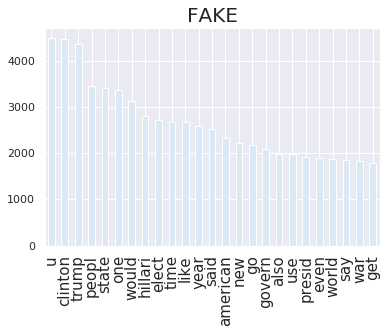

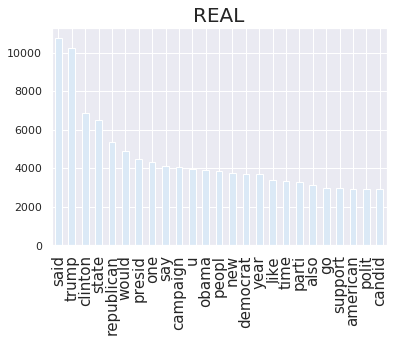

In [18]:
df = pd.DataFrame({"text": dataset[0:len(training_set)].clean_text, "CLASS": dataset[0:len(training_set)].label})
grouped = df.groupby(["CLASS"]).apply(lambda x: x["text"].sum())
grouped_df = pd.DataFrame({"CLASS": grouped.index, "text": grouped.values})

from nltk.tokenize import WhitespaceTokenizer
tokenizer = WhitespaceTokenizer()

for ii, text in enumerate(grouped_df.text):
    pd.DataFrame(tokenizer.tokenize(text)).apply(pd.value_counts).head(25).plot(kind="bar", legend=None)
    plt.title(grouped_df.CLASS[ii], fontsize=20)
    plt.xticks(fontsize=15)
    interactive(True)
    plt.show()

It looks much better now!
We have removed all the stopwords and the terms that we see now are much more representative (e.g., clinton, trump elect).

In a closer inspection, we see some interesting words such as `war`, or `world` that appear a lot among the FAKE news and might be a good indicator of them. On the contrary `said` appears a lot in the real news. It seems that when someone is literally cited (President said: "....") it is an indicator against FAKE news.

Let's start our experimentation with predictive models.

**We now split the dataset again for the creation and evaluation of the models into training and test**

Note: X_train includes the training set that I provided you and X_test the test set. y_test are the actual labels used for evaluation. I did not provided you with them.


In [19]:
X_train = dataset[0:len(training_set)][["ID", "clean_text", "clean_title"]]
y_train = dataset[0:len(training_set)][["label"]]
X_test = dataset[len(training_set):len(dataset)][["ID", "clean_text", "clean_title"]]
y_test = test_labels

Labels are in string format. It is preferred to have them numerically encoded. To that end, sklearn provides a `LabelEncoder` to facilitate this encoding

In [238]:
# Hot encoding for the labels
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y_train.label.values)
target_labels = le.classes_
encoded_y_train = le.transform(y_train.label.values)

**Vector Space Model**

We then need to convert the textual content into numerical feature vectors (i.e., Vector Space Model), applying the bags of words representation:

 - Assign an id to each word of the training set.
 - For each document `d`, count the number of occurrences of each word `w` and store it in `X[i, j]` as the value of feature `j` where `j` is the index of `w` in the dictionary

Sklearn has also some useful functions for this textual processing that we will make use of.

We are going to use the `CountVectorizer` for creating the feature vectors, which returns the Document-Term Matrix for both classes "FAKE" and "REAL" using the title or the text of the news reports.

In [22]:
count_vect = CountVectorizer(analyzer = "word") # set min_df = frequency

train_features = count_vect.fit_transform(X_train.clean_title)
test_features = count_vect.transform(X_test.clean_title)

In [43]:
train_text_features = count_vect.fit_transform(X_train.clean_text)
test_text_features = count_vect.transform(X_test.clean_text)

Now we have our dataset in the needed format that will allow us to create our baseline models

To train, evaluate and compare the models I've used different helper functions (based on the Sklearn examples):

- a function `train_and_evaluate_classifier` that takes the training data, a classifier definition and a grid to optimize the classifier to train a predictive model.

- a function `plot_learning_curve` to provide the learning curve of the algorithm, as well as the final cross validated score. This function is called inside the `train_and_evaluate_classifier` function

- a function `plot_confusion_matrix` to plot the confusion matrix of the final predictions of the select model for the test set


In [44]:
import numpy as np
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects
    """
    
    plt.figure()
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=1, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid("on") 
    if ylim:
        plt.ylim(ylim)
    plt.title(title)

In [22]:
def train_and_evaluate_classifier(X, yt, estimator, grid):
    """Train and Evaluate a estimator (defined as input parameter) on the given labeled data using accuracy."""
    
    # Cross validation
    from sklearn.model_selection import ShuffleSplit
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
      
    from sklearn.model_selection import GridSearchCV
    classifier = GridSearchCV(estimator=estimator, cv=cv,  param_grid=grid, error_score=0.0, n_jobs = -1, verbose = 5)
    
    # Train the model over and tune the parameters
    print("Training model")
    classifier.fit(X, yt)

    # CV-score
    from sklearn.model_selection import cross_val_score
    print("CV-scores for each grid configuration")
    means = classifier.cv_results_['mean_test_score']
    stds = classifier.cv_results_['std_test_score']
    for mean, std, params in sorted(zip(means, stds, classifier.cv_results_['params']), key=lambda x: -x[0]):
        print("Accuracy: %0.3f (+/-%0.03f) for params: %r" % (mean, std * 2, params))
    print()
        
    # Learning curve
    print("Learning curve for the best estimator")
    title = 'Learning Curves (' + str(estimator.__class__).replace("'>", "").split(".")[-1] + ' )'
    plot_learning_curve(classifier.best_estimator_, title, X, yt, cv=cv)
    plt.show()
    
    return classifier

In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## Approach #1: Naïve Bayes

Let's apply Naïve Bayes for the textual classification.
Remember for class that in order to predict the class of a given document we compute the "Maximum Apriori Probability":

\begin{equation*}
MAP   = max({P(c_1|w_1,...w_n), P(c_2|w_1,...,w_n)})
\end{equation*}

To compute $P(c|w_1,...w_n)$, we will use the Bayes theorem:

\begin{equation*}
P(c|w_1,...w_n) = \frac{P(w_1,...,w_n|c)P(c)}{P(w_1,...,w_n)}
\end{equation*}

Being "naive", we can assume that w_1, ..., w_n are independent among them. Therefore:

\begin{equation*}
P(w_1,...,w_n|c) = P(w_1|c)P(w_2|c) ... P(w_n|c)
\end{equation*}

### Using the title of the news

We take the `clean_title` column to create the features that are going to be used for training our model.

Training model
Fitting 5 folds for each of 1 candidates, totalling 5 fits
CV-scores for each grid configuration
Accuracy: 0.784 (+/-0.023) for params: {}

Learning curve for the best estimator


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
/home/acastellanos/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


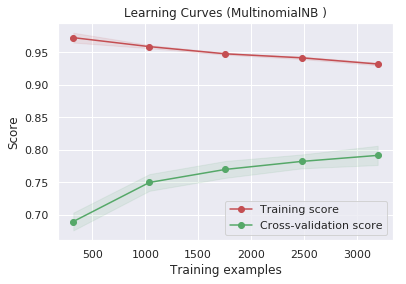

In [92]:
from sklearn.naive_bayes import MultinomialNB

# No parameters to be optimized
nb_grid= {} 

nb_text_cls = train_and_evaluate_classifier(train_features, encoded_y_train, MultinomialNB(), nb_grid)

In [93]:
print("Predicting on the test set")
y_pred = nb_text_cls.predict(test_features)

# Undo the label transformation to get the predictions as REAL or FAKE
y_pred = le.inverse_transform(y_pred)

Predicting on the test set


Classification Report
              precision    recall  f1-score   support

        FAKE       0.82      0.76      0.79      1164
        REAL       0.77      0.84      0.80      1157

   micro avg       0.80      0.80      0.80      2321
   macro avg       0.80      0.80      0.80      2321
weighted avg       0.80      0.80      0.80      2321

Confusion matrix, without normalization


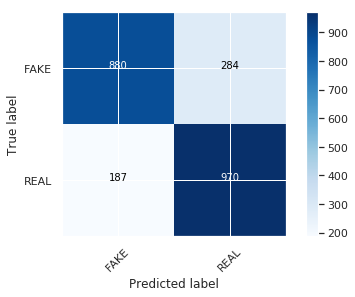

Final Accuracy
0.7970702283498492


In [94]:
print("Classification Report")
print
print(classification_report(y_test, y_pred, target_names=["FAKE", "REAL"]))
cm = confusion_matrix(y_test, y_pred, labels=["FAKE", "REAL"])
 
plot_confusion_matrix(cm, classes=["FAKE", "REAL"])

print("Final Accuracy")
print(accuracy_score(y_test, y_pred,))

By only using just the title of the news and a simple methodology like Naive Bayes we get almost an 80% of accuracy. Not bad!

Let's see if more information or more advanced methodologies can improve this baseline.

Store the results in a DataFrame for comparison

In [95]:
results_df = pd.DataFrame(columns=['Classification Approach', 'Information Source', 'NLP Preprocessing', 'Accuracy'])
results_df.loc[len(results_df)] = ['Naive Bayes', 'News Title', 'Baseline Preprocessing', accuracy_score(y_test, y_pred,)]
results_df

,Classification Approach,Information Source,NLP Preprocessing,Accuracy
0,Naive Bayes,News Title,Baseline Preprocessing,0.79707


### Using the text of the news

We use the column `clean_text` to create the features through the count vectorizer object

Training model
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


CV-scores for each grid configuration
Accuracy: 0.884 (+/-0.014) for params: {}

Learning curve for the best estimator


/home/acastellanos/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


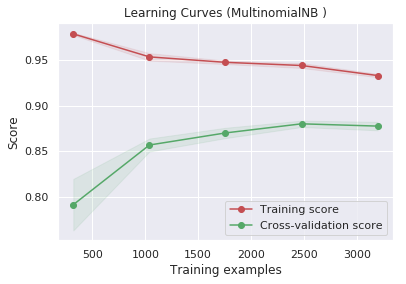

In [96]:
nb_text_cls = train_and_evaluate_classifier(train_text_features, encoded_y_train, MultinomialNB(), nb_grid)

Predicting on the test set
Classification Report
              precision    recall  f1-score   support

        FAKE       0.90      0.84      0.87      1164
        REAL       0.85      0.91      0.88      1157

   micro avg       0.87      0.87      0.87      2321
   macro avg       0.88      0.87      0.87      2321
weighted avg       0.88      0.87      0.87      2321

Confusion matrix, without normalization


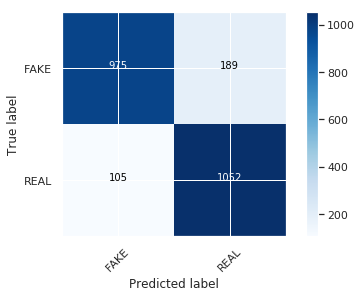

Final Accuracy
0.8733304610081861


In [97]:
print("Predicting on the test set")
y_pred = nb_text_cls.predict(test_text_features)

# Undo the label transformation to get the predictions as REAL or FAKE
y_pred = le.inverse_transform(y_pred)

print("Classification Report")
print
print(classification_report(y_test, y_pred, target_names=["FAKE", "REAL"]))
cm = confusion_matrix(y_test, y_pred, labels=["FAKE", "REAL"])
 
plot_confusion_matrix(cm, classes=["FAKE", "REAL"])

print("Final Accuracy")
print(accuracy_score(y_test, y_pred,))

In [98]:
results_df.loc[len(results_df)] = ['Naive Bayes', 'News Text', 'Baseline Preprocessing', accuracy_score(y_test, y_pred,)]
results_df

,Classification Approach,Information Source,NLP Preprocessing,Accuracy
0,Naive Bayes,News Title,Baseline Preprocessing,0.79707
1,Naive Bayes,News Text,Baseline Preprocessing,0.87333


As expected, more information means more accuracy.

### Title and Text together

Let's see if putting all the textual information together result in more accuracy.

In [23]:
dataset['text'].apply(lambda x: process_text(x))

X_train['clean_title_and_text'] = X_train[['clean_title', 'clean_text']].apply(lambda x: ' '.join(x), axis=1)
X_test['clean_title_and_text'] = X_test[['clean_title', 'clean_text']].apply(lambda x: ' '.join(x), axis=1)

train_title_and_text_features = count_vect.fit_transform(X_train.clean_title_and_text)
test_title_and_text_features = count_vect.transform(X_test.clean_title_and_text)

Training model
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


CV-scores for each grid configuration
Accuracy: 0.892 (+/-0.006) for params: {}

Learning curve for the best estimator


/home/acastellanos/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


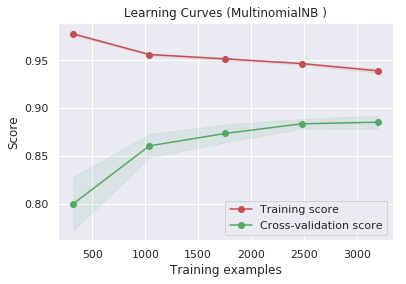

In [99]:
nb_text_cls = train_and_evaluate_classifier(train_title_and_text_features, encoded_y_train, MultinomialNB(), nb_grid)

Predicting on the test set
Classification Report
              precision    recall  f1-score   support

        FAKE       0.91      0.86      0.89      1164
        REAL       0.87      0.92      0.89      1157

   micro avg       0.89      0.89      0.89      2321
   macro avg       0.89      0.89      0.89      2321
weighted avg       0.89      0.89      0.89      2321

Confusion matrix, without normalization


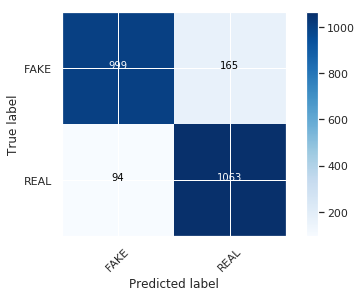

Final Accuracy
0.8884101680310211


In [100]:
print("Predicting on the test set")
y_pred = nb_text_cls.predict(test_title_and_text_features)

# Undo the label transformation to get the predictions as REAL or FAKE
y_pred = le.inverse_transform(y_pred)

print("Classification Report")
print
print(classification_report(y_test, y_pred, target_names=["FAKE", "REAL"]))
cm = confusion_matrix(y_test, y_pred, labels=["FAKE", "REAL"])
 
plot_confusion_matrix(cm, classes=["FAKE", "REAL"])

print("Final Accuracy")
print(accuracy_score(y_test, y_pred,))

In [101]:
results_df.loc[len(results_df)] = ['Naive Bayes', 'News Text and Title', 'Baseline Preprocessing', accuracy_score(y_test, y_pred,)]
results_df

,Classification Approach,Information Source,NLP Preprocessing,Accuracy
0,Naive Bayes,News Title,Baseline Preprocessing,0.79707
1,Naive Bayes,News Text,Baseline Preprocessing,0.87333
2,Naive Bayes,News Text and Title,Baseline Preprocessing,0.88841


Again, more information means a better classifier. We will use this representation for the following experiments

89% of Accuracy is a strong baseline. In this solution I am going to explore more solutions to further enhance these results. Nevertheless, if you are trying to create a production system, it could be enough. As you could have seen, it is quite easy and fast to train a NB classifier. 

Only if you actually need a state of the art classifier you could delve into the following methodologies.

## Approach 2: SVM

As seen in class, SVM is better suited for text classification, providing a more accurate model. By making use of sklearn, we are going to implement a SVM classifier and then apply it to detect fake news and check if we can improve our baseline Naïve Bayes model.


We now make use of the `train_and_evaluate_classifier` function

Training model
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.2min finished


CV-scores for each grid configuration
Accuracy: 0.896 (+/-0.021) for params: {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.889 (+/-0.024) for params: {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.884 (+/-0.018) for params: {'C': 1, 'kernel': 'linear'}
Accuracy: 0.884 (+/-0.018) for params: {'C': 10, 'kernel': 'linear'}
Accuracy: 0.884 (+/-0.018) for params: {'C': 100, 'kernel': 'linear'}
Accuracy: 0.870 (+/-0.013) for params: {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}

Learning curve for the best estimator


/home/acastellanos/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


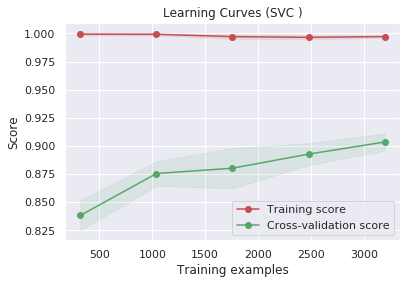

In [66]:
# SVM model
from sklearn.svm import SVC

svm_grid = [
  {'C': [1, 10, 100], 'kernel': ['linear']},
  {'C': [10, 100, 1000], 'gamma': [0.0001], 'kernel': ['rbf']},
 ]

svm_cls = train_and_evaluate_classifier(train_title_and_text_features, encoded_y_train, SVC(), svm_grid)

Let's get the best estimator and use it for predicting the test data

In [102]:
print("Best estimator found by grid search:")
print(svm_cls.best_estimator_)

Best estimator found by grid search:
SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


Once we have identified the best predictor, we use it to predict the lables on the test set.

In [103]:
print("Predicting fake news on the test set")
y_pred = svm_cls.predict(test_title_and_text_features)

# Undo the label transformation to get the predictions as REAL or FAKE
y_pred = le.inverse_transform(y_pred)

Predicting fake news on the test set


Classification Report
              precision    recall  f1-score   support

        FAKE       0.90      0.89      0.90      1164
        REAL       0.89      0.90      0.90      1157

   micro avg       0.90      0.90      0.90      2321
   macro avg       0.90      0.90      0.90      2321
weighted avg       0.90      0.90      0.90      2321

Confusion matrix, without normalization


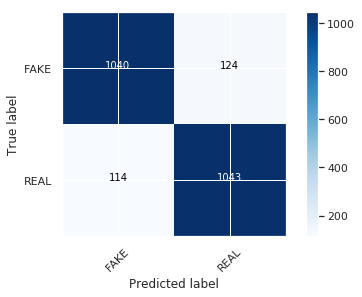

Final Accuracy
0.8974579922447221


In [104]:
print("Classification Report")
print
print(classification_report(y_test, y_pred, target_names=["FAKE", "REAL"]))
cm = confusion_matrix(y_test, y_pred, labels=["FAKE", "REAL"])
 
plot_confusion_matrix(cm, classes=["FAKE", "REAL"])

print("Final Accuracy")
print(accuracy_score(y_test, y_pred,))

In [105]:
results_df.loc[len(results_df)] = ['SVM', 'News Text and Title', 'Baseline Preprocessing', accuracy_score(y_test, y_pred,)]
results_df

,Classification Approach,Information Source,NLP Preprocessing,Accuracy
0,Naive Bayes,News Title,Baseline Preprocessing,0.797070
1,Naive Bayes,News Text,Baseline Preprocessing,0.873330
2,Naive Bayes,News Text and Title,Baseline Preprocessing,0.888410
3,SVM,News Text and Title,Baseline Preprocessing,0.897458


90% Accuracy. As expected, much better than our baseline model based on NB.

Summing up, SVM has proved to be a more suited algorithm for text classification than Naive Bayes.

# Approach #3: MaxEnt Classifiers

In class we studied the maxent classifiers. They are probabilistic models especially suited for text

Training model
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   50.0s finished
/home/acastellanos/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


CV-scores for each grid configuration
Accuracy: 0.909 (+/-0.010) for params: {'C': 0.1, 'penalty': 'l2'}
Accuracy: 0.905 (+/-0.012) for params: {'C': 1, 'penalty': 'l2'}
Accuracy: 0.904 (+/-0.014) for params: {'C': 0.01, 'penalty': 'l2'}
Accuracy: 0.903 (+/-0.018) for params: {'C': 1, 'penalty': 'l1'}
Accuracy: 0.901 (+/-0.013) for params: {'C': 10, 'penalty': 'l2'}
Accuracy: 0.896 (+/-0.012) for params: {'C': 100, 'penalty': 'l1'}
Accuracy: 0.895 (+/-0.010) for params: {'C': 100, 'penalty': 'l2'}
Accuracy: 0.893 (+/-0.011) for params: {'C': 10, 'penalty': 'l1'}
Accuracy: 0.891 (+/-0.011) for params: {'C': 1000, 'penalty': 'l2'}
Accuracy: 0.884 (+/-0.010) for params: {'C': 1000, 'penalty': 'l1'}
Accuracy: 0.883 (+/-0.015) for params: {'C': 0.001, 'penalty': 'l2'}
Accuracy: 0.881 (+/-0.010) for params: {'C': 0.1, 'penalty': 'l1'}
Accuracy: 0.822 (+/-0.003) for params: {'C': 0.01, 'penalty': 'l1'}
Accuracy: 0.657 (+/-0.036) for params: {'C': 0.001, 'penalty': 'l1'}

Learning curve for th

/home/acastellanos/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/acastellanos/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


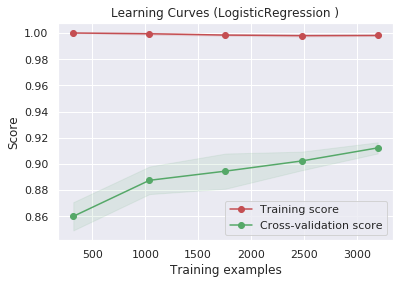

In [106]:
from sklearn.linear_model import LogisticRegression
max_ent_grid= {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}
max_ent_cls = train_and_evaluate_classifier(train_title_and_text_features, encoded_y_train, LogisticRegression(), max_ent_grid)

In [107]:
print("Best estimator found by grid search:")
print(max_ent_cls.best_estimator_)

Best estimator found by grid search:
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


In [108]:
print("Predicting fake news on the test set")
y_pred = max_ent_cls.predict(test_title_and_text_features)

# Undo the label transformation to get the predictions as REAL or FAKE
y_pred = le.inverse_transform(y_pred)

Predicting fake news on the test set


Classification Report
              precision    recall  f1-score   support

        FAKE       0.91      0.91      0.91      1164
        REAL       0.91      0.91      0.91      1157

   micro avg       0.91      0.91      0.91      2321
   macro avg       0.91      0.91      0.91      2321
weighted avg       0.91      0.91      0.91      2321

Confusion matrix, without normalization


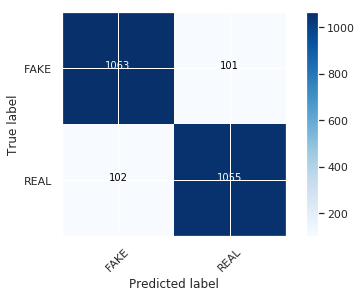

Final Accuracy
0.9125376992675571


In [109]:
print("Classification Report")
print
print(classification_report(y_test, y_pred, target_names=["FAKE", "REAL"]))
cm = confusion_matrix(y_test, y_pred, labels=["FAKE", "REAL"])
 
plot_confusion_matrix(cm, classes=["FAKE", "REAL"])

print("Final Accuracy")
print(accuracy_score(y_test, y_pred))

In [110]:
results_df.loc[len(results_df)] = ['MaxEnt', 'News Text and Title', 'Baseline Preprocessing', accuracy_score(y_test, y_pred,)]
results_df

,Classification Approach,Information Source,NLP Preprocessing,Accuracy
0,Naive Bayes,News Title,Baseline Preprocessing,0.797070
1,Naive Bayes,News Text,Baseline Preprocessing,0.873330
2,Naive Bayes,News Text and Title,Baseline Preprocessing,0.888410
3,SVM,News Text and Title,Baseline Preprocessing,0.897458
4,MaxEnt,News Text and Title,Baseline Preprocessing,0.912538


**MaxEnt Classifier outperforms SVM for this task reaching a performance close to 91 %**

As seen in class, this kind of models are highly recommended for textual classification.
In addition, as you could have experimented, they are much faster to compute than SVM. Let's stick with them for the further analysis

## Approach #4: Further improvements

In the previous exercises we have applied a basic approach based on counting the frequency of the words. Regarding the textual processing, we only applied a basic pipeline (stopword removal, tokenizing, stemming). Let us try different techniques to improve our model.

### POS Tagging

Part of speech tagging is useful to identify the role played for each term in an sentence: noun, verb, adjectives. In the context of text classification, this annotation is useful in two ways:
- **Dissambiguate between different words:** Book(Noun) and Book(Verb). This kind of ambiguity could lead the classifier to learn wrong relationships betweent texts: I should book a flight == I am reading a book.
    
- **Feature selection:** Focus on specific types of words; e.g., nouns. Some works have concluded that the use of specific parts of speech like nouns improve the results for text categorization (The Role of Parts-of-Speech in Feature Selection: https://pdfs.semanticscholar.org/5807/8a47a09a1ecd7a484f491fcd47669d0c24fc.pdf)

Let's define a function to apply pos tagging to the clean text. To create the pos tagging, NLTK provides the `pos_tag` function.

In [111]:
import nltk

def pos_tagging(text):
    pos_text = nltk.pos_tag(nltk.word_tokenize(text))
    return " ".join([t + "_" + pos for t, pos in pos_text])

In [112]:
pos_tagging('This is a sentence')

'This_DT is_VBZ a_DT sentence_NN'

We apply this function to the `clean_text` column to create a new column `pos_tagged_text` column.

We will train a classifier with this new representation and compare its results to the previous MaxEnt Classifier without the POS tagging

In [240]:
X_train['pos_tagged_text'] = X_train.clean_title_and_text.apply(pos_tagging)
X_test['pos_tagged_text'] = X_test.clean_title_and_text.apply(pos_tagging)

train_pos_text_features = count_vect.fit_transform(X_train.pos_tagged_text)
test_pos_text_features = count_vect.transform(X_test.pos_tagged_text)


In [241]:
X_train.head()

,ID,clean_text,clean_title,clean_title_and_text,pos_tagged_text
0,8476,daniel greenfield shillman journal fellow free...,smell hillari fear,smell hillari fear daniel greenfield shillman ...,smell_NN hillari_NNS fear_VBP daniel_JJ greenf...
1,10294,googl pinterest digg linkedin reddit stumbleup...,watch exact moment paul ryan commit polit suic...,watch exact moment paul ryan commit polit suic...,watch_NN exact_JJ moment_NN paul_NN ryan_JJ co...
2,3608,u secretari state john f kerri said monday sto...,kerri go pari gestur sympathi,kerri go pari gestur sympathi u secretari stat...,kerri_NN go_VBP pari_JJ gestur_NN sympathi_NN ...
3,10142,kayde king kaydeek novemb lesson tonight dem l...,berni support twitter erupt anger dnc tri warn,berni support twitter erupt anger dnc tri warn...,berni_JJ support_NN twitter_NN erupt_NN anger_...
4,875,primari day new york front runner hillari clin...,battl new york primari matter,battl new york primari matter primari day new ...,battl_JJ new_JJ york_NN primari_NN matter_NN p...


Training model
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  1.1min finished
/home/acastellanos/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


CV-scores for each grid configuration
Accuracy: 0.902 (+/-0.011) for params: {'C': 0.1, 'penalty': 'l2'}
Accuracy: 0.899 (+/-0.010) for params: {'C': 1, 'penalty': 'l2'}
Accuracy: 0.898 (+/-0.018) for params: {'C': 100, 'penalty': 'l1'}
Accuracy: 0.895 (+/-0.012) for params: {'C': 10, 'penalty': 'l2'}
Accuracy: 0.891 (+/-0.006) for params: {'C': 0.01, 'penalty': 'l2'}
Accuracy: 0.890 (+/-0.023) for params: {'C': 1, 'penalty': 'l1'}
Accuracy: 0.890 (+/-0.019) for params: {'C': 10, 'penalty': 'l1'}
Accuracy: 0.889 (+/-0.012) for params: {'C': 1000, 'penalty': 'l1'}
Accuracy: 0.886 (+/-0.010) for params: {'C': 100, 'penalty': 'l2'}
Accuracy: 0.879 (+/-0.003) for params: {'C': 1000, 'penalty': 'l2'}
Accuracy: 0.870 (+/-0.015) for params: {'C': 0.1, 'penalty': 'l1'}
Accuracy: 0.868 (+/-0.014) for params: {'C': 0.001, 'penalty': 'l2'}
Accuracy: 0.801 (+/-0.018) for params: {'C': 0.01, 'penalty': 'l1'}
Accuracy: 0.658 (+/-0.037) for params: {'C': 0.001, 'penalty': 'l1'}

Learning curve for th

/home/acastellanos/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/acastellanos/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


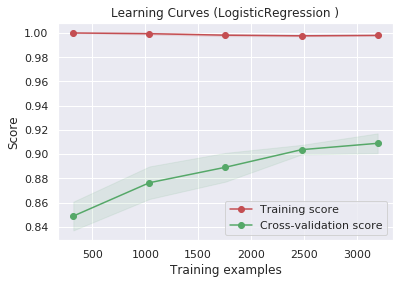

In [116]:
max_ent_pos_cls = train_and_evaluate_classifier(train_pos_text_features, encoded_y_train, LogisticRegression(), max_ent_grid)

In [117]:
print("Best estimator found by grid search:")
print(max_ent_pos_cls.best_estimator_)

Best estimator found by grid search:
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


In [118]:
print("Predicting fake news on the test set")
y_pred = max_ent_pos_cls.predict(test_pos_text_features)

# Undo the label transformation to get the predictions as REAL or FAKE
y_pred = le.inverse_transform(y_pred)

Predicting fake news on the test set


Classification Report
              precision    recall  f1-score   support

        FAKE       0.90      0.91      0.91      1164
        REAL       0.91      0.90      0.91      1157

   micro avg       0.91      0.91      0.91      2321
   macro avg       0.91      0.91      0.91      2321
weighted avg       0.91      0.91      0.91      2321

Confusion matrix, without normalization


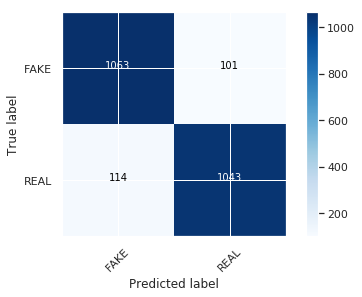

Final Accuracy
0.9073675140025851


In [119]:
print("Classification Report")
print
print(classification_report(y_test, y_pred, target_names=["FAKE", "REAL"]))
cm = confusion_matrix(y_test, y_pred, labels=["FAKE", "REAL"])
 
plot_confusion_matrix(cm, classes=["FAKE", "REAL"])

print("Final Accuracy")
print(accuracy_score(y_test, y_pred))

In [120]:
results_df.loc[len(results_df)] = ['MaxEnt', 'News Text and Title', 'POS', accuracy_score(y_test, y_pred,)]
results_df

,Classification Approach,Information Source,NLP Preprocessing,Accuracy
0,Naive Bayes,News Title,Baseline Preprocessing,0.797070
1,Naive Bayes,News Text,Baseline Preprocessing,0.873330
2,Naive Bayes,News Text and Title,Baseline Preprocessing,0.888410
3,SVM,News Text and Title,Baseline Preprocessing,0.897458
4,MaxEnt,News Text and Title,Baseline Preprocessing,0.912538
5,MaxEnt,News Text and Title,POS,0.907368


The performance is quite similar to the model without POS tagging.
Since POS tagging is time-consuming, it does not seem that including this tag could make sense.

Let's try another idea: select only the nouns. This will lead to a small and more compact representation and, as suggested in some papers, it could even improve the classifier performance

In [121]:
def pos_tagging_only_nouns(text):
    import nltk
    pos_text = nltk.pos_tag(nltk.word_tokenize(text))
    return " ".join([t + "_" + pos for t, pos in pos_text if pos in ['NN', 'NNP', 'NNPS', 'NNS']])

In [122]:
pos_tagging_only_nouns('This is a sentence')

'sentence_NN'

In [123]:
X_train['nouns'] = X_train.clean_title_and_text.apply(pos_tagging_only_nouns)
X_test['nouns'] = X_test.clean_title_and_text.apply(pos_tagging_only_nouns)

train_nouns_features = count_vect.fit_transform(X_train.nouns)
test_nouns_features = count_vect.transform(X_test.nouns)

Training model
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   49.1s finished
/home/acastellanos/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


CV-scores for each grid configuration
Accuracy: 0.890 (+/-0.027) for params: {'C': 0.1, 'penalty': 'l2'}
Accuracy: 0.882 (+/-0.023) for params: {'C': 1, 'penalty': 'l2'}
Accuracy: 0.881 (+/-0.014) for params: {'C': 100, 'penalty': 'l1'}
Accuracy: 0.880 (+/-0.019) for params: {'C': 0.01, 'penalty': 'l2'}
Accuracy: 0.879 (+/-0.023) for params: {'C': 1, 'penalty': 'l1'}
Accuracy: 0.875 (+/-0.012) for params: {'C': 10, 'penalty': 'l2'}
Accuracy: 0.874 (+/-0.013) for params: {'C': 10, 'penalty': 'l1'}
Accuracy: 0.866 (+/-0.011) for params: {'C': 100, 'penalty': 'l2'}
Accuracy: 0.865 (+/-0.020) for params: {'C': 1000, 'penalty': 'l1'}
Accuracy: 0.860 (+/-0.017) for params: {'C': 0.001, 'penalty': 'l2'}
Accuracy: 0.857 (+/-0.022) for params: {'C': 0.1, 'penalty': 'l1'}
Accuracy: 0.848 (+/-0.020) for params: {'C': 1000, 'penalty': 'l2'}
Accuracy: 0.793 (+/-0.026) for params: {'C': 0.01, 'penalty': 'l1'}
Accuracy: 0.565 (+/-0.048) for params: {'C': 0.001, 'penalty': 'l1'}

Learning curve for th

/home/acastellanos/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/acastellanos/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


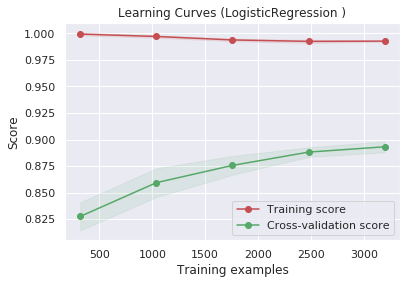

In [124]:
max_ent_noun_cls = train_and_evaluate_classifier(train_nouns_features, encoded_y_train, LogisticRegression(), max_ent_grid)

In [125]:
print("Best estimator found by grid search:")
print(max_ent_noun_cls.best_estimator_)

Best estimator found by grid search:
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


In [126]:
print("Predicting fake news on the test set")
y_pred = max_ent_noun_cls.predict(test_nouns_features)

# Undo the label transformation to get the predictions as REAL or FAKE
y_pred = le.inverse_transform(y_pred)

Predicting fake news on the test set


Classification Report
              precision    recall  f1-score   support

        FAKE       0.89      0.91      0.90      1164
        REAL       0.90      0.89      0.90      1157

   micro avg       0.90      0.90      0.90      2321
   macro avg       0.90      0.90      0.90      2321
weighted avg       0.90      0.90      0.90      2321

Confusion matrix, without normalization


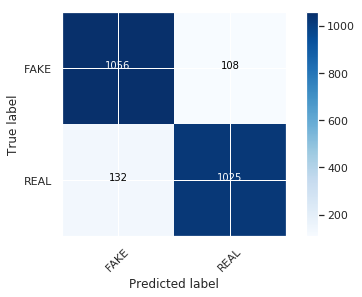

Final Accuracy
0.8965962947005601


In [127]:
print("Classification Report")
print
print(classification_report(y_test, y_pred, target_names=["FAKE", "REAL"]))
cm = confusion_matrix(y_test, y_pred, labels=["FAKE", "REAL"])
 
plot_confusion_matrix(cm, classes=["FAKE", "REAL"])

print("Final Accuracy")
print(accuracy_score(y_test, y_pred))

In [128]:
results_df.loc[len(results_df)] = ['MaxEnt', 'News Text and Title', 'POS only Nouns', accuracy_score(y_test, y_pred,)]
results_df

,Classification Approach,Information Source,NLP Preprocessing,Accuracy
0,Naive Bayes,News Title,Baseline Preprocessing,0.797070
1,Naive Bayes,News Text,Baseline Preprocessing,0.873330
2,Naive Bayes,News Text and Title,Baseline Preprocessing,0.888410
3,SVM,News Text and Title,Baseline Preprocessing,0.897458
4,MaxEnt,News Text and Title,Baseline Preprocessing,0.912538
5,MaxEnt,News Text and Title,POS,0.907368
6,MaxEnt,News Text and Title,POS only Nouns,0.896596


We have achieved almost the same performance by only using the nouns but with half the features (see the following cell).

In this notebook, we are trying to get the best possible model so we are not going to consider this approach. However, it might make sense for production system to rely on this kind of approaches that provides almost the same performance with a much faster model.

In [129]:
print("Size of the training set: ", train_pos_text_features.shape, "vs Size of the only-noun training set", train_nouns_features.shape)

Size of the training set:  (3997, 79069) vs Size of the only-noun training set (3997, 33641)


### Dependency Parsing

Dependency Parsing is useful to discover the relationships between words in the sentence: main verb and their modifiers, verb and objects, subject and objects...

For text classification, you can use this annotation to extract the relationship tree of the sentence or to even extract specific subtrees (group of relationships), such as: subject and object or verb and object.

I am using the dependency parser provided by the Stanford Core NLP. I have download the Core NLP server and execute it in my localhost. It will create an endpoint in your localhost (in the port 9000 by default) that you can use to parse the data. For more detail on how to install and use the Core NLP server, check the following link: https://stanfordnlp.github.io/CoreNLP/corenlp-server.html. 

To use the Core NLP server, NLTK provides and useful parser `CoreNLPDependencyParser`:


In [132]:
from nltk.parse.corenlp import CoreNLPDependencyParser
dep_parser = CoreNLPDependencyParser('http://localhost:9000')

In [173]:
def dependency_parsing(text):
    if text.strip() is None or len(text.strip()) < 3:
        return ''
    dep_parse = list(next(dep_parser.raw_parse(text.strip())).triples())
    subj_obj = filter(lambda v : v[1] == 'nsubj' or v[1] == 'dobj', dep_parse)
    return "".join([so[0][0]+"-"+so[0][1] + "_" + so[1] + "_" + so[2][0]+"-"+so[2][1] for so in subj_obj])

In [174]:
dependency_parsing('This is a sentence')

'sentence-NN_nsubj_This-DT'

To create the dependency parsing we need the original text without modifications. Therefore, we select the original `text` column in the dataset instead of the `clean_text` column.

**Warning**: Dependency Parsing is a complex process, so the following code is going to take a while.

In [242]:
X_train['dependency_parsed_text'] = dataset[0:len(training_set)]['text'].apply(dependency_parsing)
X_test['dependency_parsed_text'] = dataset[len(training_set):len(dataset)]['text'].apply(dependency_parsing)

In [176]:
train_dep_features = count_vect.fit_transform(X_train.dependency_parsed_text.apply(lambda x: np.str_(x)))
test_dep_features = count_vect.transform(X_test.dependency_parsed_text.apply(lambda x: np.str_(x)))

Since the dependency parsing is very slow and I do not want to repeat the process, let's save the dataframes as CSV for later uses


In [243]:
# Saving model
X_train.to_csv('./processed_X_train.csv', sep=",")
X_test.to_csv('./processed_X_test.csv', sep=",")

In [161]:
# # Loading model
# X_train = pd.read_csv('./processed_X_train.csv', sep=",")
# X_test = pd.read_csv('./processed_X_test.csv', sep=",")

Training model
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    4.4s finished


CV-scores for each grid configuration
Accuracy: 0.557 (+/-0.024) for params: {'C': 1, 'penalty': 'l2'}
Accuracy: 0.554 (+/-0.015) for params: {'C': 0.1, 'penalty': 'l2'}
Accuracy: 0.554 (+/-0.029) for params: {'C': 10, 'penalty': 'l2'}
Accuracy: 0.551 (+/-0.019) for params: {'C': 100, 'penalty': 'l2'}
Accuracy: 0.547 (+/-0.027) for params: {'C': 10, 'penalty': 'l1'}
Accuracy: 0.544 (+/-0.014) for params: {'C': 1000, 'penalty': 'l2'}
Accuracy: 0.544 (+/-0.014) for params: {'C': 100, 'penalty': 'l1'}
Accuracy: 0.539 (+/-0.008) for params: {'C': 1000, 'penalty': 'l1'}
Accuracy: 0.539 (+/-0.011) for params: {'C': 0.01, 'penalty': 'l2'}
Accuracy: 0.535 (+/-0.013) for params: {'C': 1, 'penalty': 'l1'}
Accuracy: 0.509 (+/-0.020) for params: {'C': 0.001, 'penalty': 'l1'}
Accuracy: 0.509 (+/-0.020) for params: {'C': 0.01, 'penalty': 'l1'}
Accuracy: 0.505 (+/-0.029) for params: {'C': 0.1, 'penalty': 'l1'}
Accuracy: 0.503 (+/-0.034) for params: {'C': 0.001, 'penalty': 'l2'}

Learning curve for th

/home/acastellanos/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/acastellanos/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


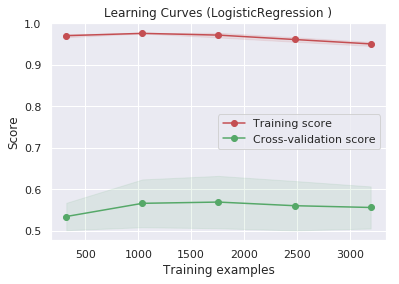

In [179]:
max_ent_dep_cls = train_and_evaluate_classifier(train_dep_features, encoded_y_train, LogisticRegression(), max_ent_grid)

In [180]:
print("Best estimator found by grid search:")
print(max_ent_dep_cls.best_estimator_)

Best estimator found by grid search:
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


In [181]:
print("Predicting fake news on the test set")
y_pred = max_ent_dep_cls.predict(test_dep_features)

# Undo the label transformation to get the predictions as REAL or FAKE
y_pred = le.inverse_transform(y_pred)

Predicting fake news on the test set


Classification Report
              precision    recall  f1-score   support

        FAKE       0.66      0.63      0.64      1164
        REAL       0.64      0.67      0.65      1157

   micro avg       0.65      0.65      0.65      2321
   macro avg       0.65      0.65      0.65      2321
weighted avg       0.65      0.65      0.65      2321

Confusion matrix, without normalization


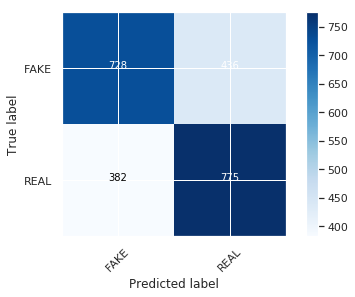

Final Accuracy
0.6475657044377423


In [182]:
print("Classification Report")
print
print(classification_report(y_test, y_pred, target_names=["FAKE", "REAL"]))
cm = confusion_matrix(y_test, y_pred, labels=["FAKE", "REAL"])
 
plot_confusion_matrix(cm, classes=["FAKE", "REAL"])

print("Final Accuracy")
print(accuracy_score(y_test, y_pred))

In [183]:
results_df.loc[len(results_df)] = ['MaxEnt', 'News Text and Title', 'Dependency Parsing', accuracy_score(y_test, y_pred,)]
results_df

,Classification Approach,Information Source,NLP Preprocessing,Accuracy
0,Naive Bayes,News Title,Baseline Preprocessing,0.797070
1,Naive Bayes,News Text,Baseline Preprocessing,0.873330
2,Naive Bayes,News Text and Title,Baseline Preprocessing,0.888410
3,SVM,News Text and Title,Baseline Preprocessing,0.897458
4,MaxEnt,News Text and Title,Baseline Preprocessing,0.912538
5,MaxEnt,News Text and Title,POS,0.907368
6,MaxEnt,News Text and Title,POS only Nouns,0.896596
7,MaxEnt,News Text and Title,Dependency Parsing,0.647566
8,MaxEnt,News Text and Title,POS + Dependency Parsing,0.912107


Just using the detected dependencies do not achieve the same performance than by using the whole text.

Again we have to achieve a compromise between the accuracy of the model and the reduced amount of data that we are using by considering only the dependencies.

#### All together

I will finally try to combine all the previous features together to experiment if their combination can improve the model.

This model will aslo take a while to train.

In [244]:
X_train["all"] = X_train[['clean_title_and_text', 'dependency_parsed_text', 'pos_tagged_text']].apply(lambda x: ''.join(x.apply(lambda x: np.str_(x))), axis=1)
X_test["all"] = X_test[['clean_title_and_text', 'dependency_parsed_text', 'pos_tagged_text']].apply(lambda x: ''.join(x.apply(lambda x: np.str_(x))), axis=1)

train_all_features = count_vect.fit_transform(X_train['all'])
test_all_features = count_vect.transform(X_test['all'])

Training model
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  1.7min finished


CV-scores for each grid configuration
Accuracy: 0.908 (+/-0.010) for params: {'C': 0.1, 'penalty': 'l2'}
Accuracy: 0.904 (+/-0.013) for params: {'C': 1, 'penalty': 'l2'}
Accuracy: 0.901 (+/-0.016) for params: {'C': 1, 'penalty': 'l1'}
Accuracy: 0.901 (+/-0.014) for params: {'C': 10, 'penalty': 'l2'}
Accuracy: 0.901 (+/-0.007) for params: {'C': 0.01, 'penalty': 'l2'}
Accuracy: 0.900 (+/-0.013) for params: {'C': 10, 'penalty': 'l1'}
Accuracy: 0.899 (+/-0.012) for params: {'C': 100, 'penalty': 'l1'}
Accuracy: 0.893 (+/-0.017) for params: {'C': 100, 'penalty': 'l2'}
Accuracy: 0.888 (+/-0.015) for params: {'C': 0.001, 'penalty': 'l2'}
Accuracy: 0.888 (+/-0.018) for params: {'C': 1000, 'penalty': 'l2'}
Accuracy: 0.882 (+/-0.028) for params: {'C': 1000, 'penalty': 'l1'}
Accuracy: 0.880 (+/-0.011) for params: {'C': 0.1, 'penalty': 'l1'}
Accuracy: 0.818 (+/-0.012) for params: {'C': 0.01, 'penalty': 'l1'}
Accuracy: 0.658 (+/-0.035) for params: {'C': 0.001, 'penalty': 'l1'}

Learning curve for th

/home/acastellanos/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/acastellanos/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


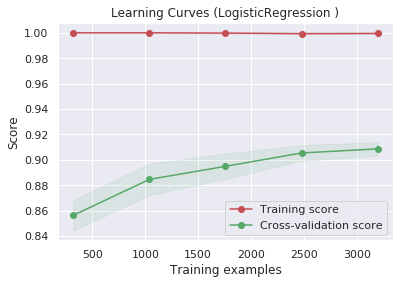

In [185]:
max_ent_all_cls = train_and_evaluate_classifier(train_all_features, encoded_y_train, LogisticRegression(), max_ent_grid)

In [186]:
print("Best estimator found by grid search:")
print(max_ent_all_cls.best_estimator_)

Best estimator found by grid search:
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


In [187]:
print("Predicting fake news on the test set")
y_pred = max_ent_all_cls.predict(test_all_features)

# Undo the label transformation to get the predictions as REAL or FAKE
y_pred = le.inverse_transform(y_pred)

Predicting fake news on the test set


Classification Report
              precision    recall  f1-score   support

        FAKE       0.91      0.92      0.91      1164
        REAL       0.92      0.91      0.91      1157

   micro avg       0.91      0.91      0.91      2321
   macro avg       0.91      0.91      0.91      2321
weighted avg       0.91      0.91      0.91      2321

Confusion matrix, without normalization


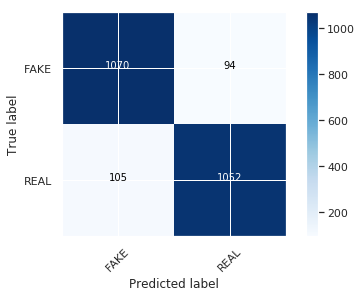

Final Accuracy
0.9142610943558811


In [188]:
print("Classification Report")
print
print(classification_report(y_test, y_pred, target_names=["FAKE", "REAL"]))
cm = confusion_matrix(y_test, y_pred, labels=["FAKE", "REAL"])
 
plot_confusion_matrix(cm, classes=["FAKE", "REAL"])

print("Final Accuracy")
print(accuracy_score(y_test, y_pred))

In [189]:
results_df.loc[len(results_df)] = ['MaxEnt', 'News Text and Title', 'POS + Dependency Parsing', accuracy_score(y_test, y_pred,)]
results_df

,Classification Approach,Information Source,NLP Preprocessing,Accuracy
0,Naive Bayes,News Title,Baseline Preprocessing,0.797070
1,Naive Bayes,News Text,Baseline Preprocessing,0.873330
2,Naive Bayes,News Text and Title,Baseline Preprocessing,0.888410
3,SVM,News Text and Title,Baseline Preprocessing,0.897458
4,MaxEnt,News Text and Title,Baseline Preprocessing,0.912538
5,MaxEnt,News Text and Title,POS,0.907368
6,MaxEnt,News Text and Title,POS only Nouns,0.896596
7,MaxEnt,News Text and Title,Dependency Parsing,0.647566
8,MaxEnt,News Text and Title,POS + Dependency Parsing,0.914261


**91.5%**: It seems that giving all the additional information to the classiffier makes sense. The more data it has the better the classification.

Let's use this representation.

### TF-IDF weighting

The first process is to improve the weighting of the terms by applying TF-IDF. By better weighting the terms, it is expected to improve the data representation and, consequently, the performance of the classifiers

In [190]:
from sklearn.feature_extraction.text import TfidfTransformer

count_vect = CountVectorizer(analyzer = "word") # set min_df = frequency
train_features = count_vect.fit_transform(X_train['all'])
test_features = count_vect.transform(X_test['all'])

tfidf = TfidfTransformer(norm="l2")
train_text_tfidf_features = tfidf.fit_transform(train_features)
test_text_tfidf_features = tfidf.fit_transform(test_features)                
                         

Training model
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   30.4s finished


CV-scores for each grid configuration
Accuracy: 0.922 (+/-0.012) for params: {'C': 100, 'penalty': 'l2'}
Accuracy: 0.922 (+/-0.014) for params: {'C': 1000, 'penalty': 'l2'}
Accuracy: 0.920 (+/-0.010) for params: {'C': 10, 'penalty': 'l1'}
Accuracy: 0.920 (+/-0.008) for params: {'C': 100, 'penalty': 'l1'}
Accuracy: 0.919 (+/-0.011) for params: {'C': 1000, 'penalty': 'l1'}
Accuracy: 0.917 (+/-0.008) for params: {'C': 10, 'penalty': 'l2'}
Accuracy: 0.891 (+/-0.008) for params: {'C': 1, 'penalty': 'l2'}
Accuracy: 0.860 (+/-0.012) for params: {'C': 1, 'penalty': 'l1'}
Accuracy: 0.848 (+/-0.021) for params: {'C': 0.1, 'penalty': 'l2'}
Accuracy: 0.813 (+/-0.039) for params: {'C': 0.01, 'penalty': 'l2'}
Accuracy: 0.753 (+/-0.008) for params: {'C': 0.1, 'penalty': 'l1'}
Accuracy: 0.537 (+/-0.126) for params: {'C': 0.001, 'penalty': 'l2'}
Accuracy: 0.509 (+/-0.020) for params: {'C': 0.001, 'penalty': 'l1'}
Accuracy: 0.509 (+/-0.020) for params: {'C': 0.01, 'penalty': 'l1'}

Learning curve for th

/home/acastellanos/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/acastellanos/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


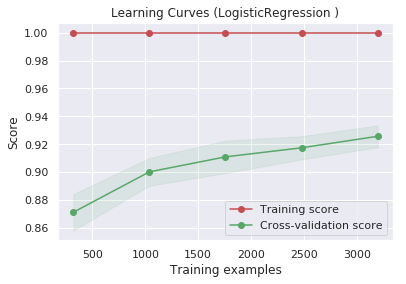

In [191]:
max_ent_tfidf_cls = train_and_evaluate_classifier(train_text_tfidf_features, encoded_y_train, LogisticRegression(), max_ent_grid)

In [192]:
print("Best estimator found by grid search:")
print(max_ent_tfidf_cls.best_estimator_)

Best estimator found by grid search:
LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


In [193]:
print("Predicting fake news on the test set")
y_pred = max_ent_tfidf_cls.predict(test_text_tfidf_features)

# Undo the label transformation to get the predictions as REAL or FAKE
y_pred = le.inverse_transform(y_pred)

Predicting fake news on the test set


Classification Report
              precision    recall  f1-score   support

        FAKE       0.93      0.94      0.93      1164
        REAL       0.94      0.92      0.93      1157

   micro avg       0.93      0.93      0.93      2321
   macro avg       0.93      0.93      0.93      2321
weighted avg       0.93      0.93      0.93      2321

Confusion matrix, without normalization


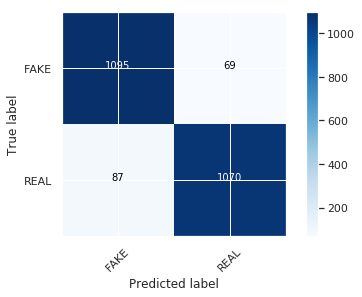

Final Accuracy
0.9327875915553641


In [194]:
print("Classification Report")
print
print(classification_report(y_test, y_pred, target_names=["FAKE", "REAL"]))
cm = confusion_matrix(y_test, y_pred, labels=["FAKE", "REAL"])
 
plot_confusion_matrix(cm, classes=["FAKE", "REAL"])

print("Final Accuracy")
print(accuracy_score(y_test, y_pred))

In [195]:
results_df.loc[len(results_df)] = ['MaxEnt', 'News Text and Title', 'POS + Dependency Parsing + TF-IDF', accuracy_score(y_test, y_pred,)]
results_df

,Classification Approach,Information Source,NLP Preprocessing,Accuracy
0,Naive Bayes,News Title,Baseline Preprocessing,0.797070
1,Naive Bayes,News Text,Baseline Preprocessing,0.873330
2,Naive Bayes,News Text and Title,Baseline Preprocessing,0.888410
3,SVM,News Text and Title,Baseline Preprocessing,0.897458
4,MaxEnt,News Text and Title,Baseline Preprocessing,0.912538
5,MaxEnt,News Text and Title,POS,0.907368
6,MaxEnt,News Text and Title,POS only Nouns,0.896596
7,MaxEnt,News Text and Title,Dependency Parsing,0.647566
8,MaxEnt,News Text and Title,POS + Dependency Parsing,0.914261
9,MaxEnt,News Text and Title,POS + Dependency Parsing + TF-IDF,0.932788


**We have got a large improvement by applying TF-IDF: from 91 to 93%**.

For some task, for instance when you are dealing with small texts (e.g. Twitter) or text with a small set of words highly important (e.g., sentiment analysis where you focus on a small set of sentiment-carrying terms), simpler weighting approaches like TF or binary weighting are enough to capture the semantics of the documents.

However, for richer (i.e., larger) textual representations, usually TF-IDF offers a better performance.

As a rule of thumb, you should start with simple binary or frequency-based

Let's take a look to the weightings

Here we plot the 20 most frequent words in FAKE and REAL classes

In [246]:
count_vect = CountVectorizer(analyzer = "word") # set min_df = frequency
dataset['all'] = pd.concat([X_train, X_test])['all']
fake_features = count_vect.fit_transform(dataset[np.array(pandas.concat([pd.concat([X_train, X_test]), pd.concat([y_train, y_test])], axis=1).label == "FAKE")]['all'])

fake_occ = np.asarray(fake_features.sum(axis=0)).ravel().tolist()

counts_df = pandas.DataFrame({'term': count_vect.get_feature_names(), 'occurrences': fake_occ})
counts_df.sort_values(by='occurrences', ascending=False).head(20)

,term,occurrences
13779,clinton,4696
82445,trump,4678
13782,clinton_nn,4197
83116,u_jj,4063
82451,trump_nn,3799
60425,peopl,3485
76619,state_nn,3449
76618,state,3448
57624,one,3405
57625,one_cd,3396


Now, we plot the 20 features with largest TF-IDF value

In [249]:
transformer = TfidfTransformer()
fake_features = count_vect.fit_transform(dataset[np.array(pandas.concat([pd.concat([X_train, X_test]), pd.concat([y_train, y_test])], axis=1).label == "FAKE")]['all'])
transformed_weights = transformer.fit_transform(fake_features)

weights = np.asarray(transformed_weights.mean(axis=0)).ravel().tolist()
weights_df = pandas.DataFrame({'term': count_vect.get_feature_names(), 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head(20)

,term,weight
82445,trump,0.029751
13779,clinton,0.028428
13782,clinton_nn,0.025858
82451,trump_nn,0.024521
34050,hillari,0.020672
23120,elect,0.017008
83116,u_jj,0.016969
60425,peopl,0.014232
76619,state_nn,0.013860
76618,state,0.013854


TF-IDF promotes terms with discriminative power (i.e, they appear in the FAKE but not in the REAL class). It makes common terms like `u` to lose weight w.r.t. the counts (i.e., as it is a common term, it appears in both classes and its TF-IDF is lower). Other terms like `vote` or `fbi` which were not among the most important ones when the counts are considered, they are when TF-IDF is used.



**Now with the REAL news**

In [248]:
real_features = count_vect.fit_transform(dataset[np.array(pandas.concat([pd.concat([X_train, X_test]), pd.concat([y_train, y_test])], axis=1).label == "REAL")]['all'])
real_occ = np.asarray(real_features.sum(axis=0)).ravel().tolist()

counts_df = pandas.DataFrame({'term': count_vect.get_feature_names(), 'occurrences': real_occ})
counts_df.sort_values(by='occurrences', ascending=False).head(20)

,term,occurrences
62695,said_vbd,10821
62694,said,10744
73738,trump,10702
73746,trump_nn,8495
12458,clinton,7149
68379,state_nn,6564
68378,state,6561
12462,clinton_nn,6291
60545,republican,5482
60546,republican_jj,5143


In [250]:
real_features = count_vect.fit_transform(dataset[np.array(pandas.concat([pd.concat([X_train, X_test]), pd.concat([y_train, y_test])], axis=1).label == "REAL")]['all'])
transformed_weights = transformer.fit_transform(real_features)

weights = np.asarray(transformed_weights.mean(axis=0)).ravel().tolist()
weights_df = pandas.DataFrame({'term': count_vect.get_feature_names(), 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head(20)

,term,weight
73738,trump,0.054596
73746,trump_nn,0.043935
12458,clinton,0.036122
62695,said_vbd,0.034892
62694,said,0.034541
12462,clinton_nn,0.032040
60545,republican,0.023547
68379,state_nn,0.022574
68378,state,0.022535
60546,republican_jj,0.022233


In addition to check the improvement in representation made by TF-IDF, inspecting the most important features of each class allows us to identify another aspect. The POS and dependency parsing annotations does not seem to provide much information (in addition to what is provided by the terms in the news). For instance, `said_vbd` and `said`, or `trump` and `trump_nn` offer the same information. Since POS Tagging requires a lot of pre-processing time, we are not going to take them into account for the final model.


### Feature Selection

We are using all the features (terms) to create the classifier. However, my guess is that just a small set of terms are important for the classification. Consequently, we have a "long tail" of term that are barely important for the classification process. Let's see if we can apply some feature selection process to remove them and check if the performance of the classifier remains.

In ML2 we explained Chi-Squared selection, let's apply it here.


In [251]:
tfidf = TfidfVectorizer(norm="l2")
train_text_tfidf_features = tfidf.fit_transform(X_train.clean_title_and_text)
test_text_tfidf_features = tfidf.transform(X_test.clean_title_and_text) 

feature_names = tfidf.get_feature_names()
ch2 = SelectKBest(chi2, k=5000)
train_text_tfidf_ch2_features = ch2.fit_transform(train_text_tfidf_features, y_train)
test_text_tfidf_ch2_features = ch2.transform(test_text_tfidf_features)
selected_feature_names = [feature_names[i] for i in ch2.get_support(indices=True)]

In [252]:
print("Features reduced from ", len(feature_names), "to", len(selected_feature_names))

Features reduced from  35816 to 5000


Training model
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    6.4s finished
/home/acastellanos/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


CV-scores for each grid configuration
Accuracy: 0.930 (+/-0.016) for params: {'C': 100, 'penalty': 'l2'}
Accuracy: 0.929 (+/-0.018) for params: {'C': 1000, 'penalty': 'l2'}
Accuracy: 0.927 (+/-0.011) for params: {'C': 10, 'penalty': 'l2'}
Accuracy: 0.922 (+/-0.016) for params: {'C': 10, 'penalty': 'l1'}
Accuracy: 0.921 (+/-0.008) for params: {'C': 1000, 'penalty': 'l1'}
Accuracy: 0.915 (+/-0.012) for params: {'C': 100, 'penalty': 'l1'}
Accuracy: 0.898 (+/-0.012) for params: {'C': 1, 'penalty': 'l2'}
Accuracy: 0.882 (+/-0.020) for params: {'C': 1, 'penalty': 'l1'}
Accuracy: 0.856 (+/-0.023) for params: {'C': 0.1, 'penalty': 'l2'}
Accuracy: 0.827 (+/-0.028) for params: {'C': 0.01, 'penalty': 'l2'}
Accuracy: 0.770 (+/-0.008) for params: {'C': 0.1, 'penalty': 'l1'}
Accuracy: 0.561 (+/-0.154) for params: {'C': 0.001, 'penalty': 'l2'}
Accuracy: 0.509 (+/-0.020) for params: {'C': 0.001, 'penalty': 'l1'}
Accuracy: 0.509 (+/-0.020) for params: {'C': 0.01, 'penalty': 'l1'}

Learning curve for th

/home/acastellanos/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/acastellanos/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


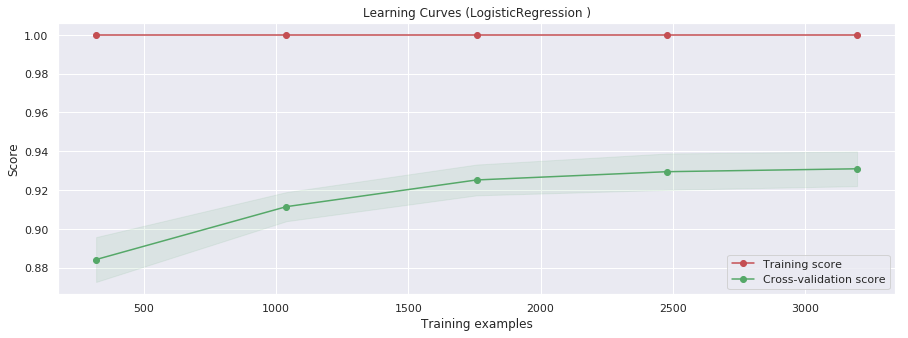

In [253]:
max_ent_chi2_cls = train_and_evaluate_classifier(train_text_tfidf_ch2_features, encoded_y_train, LogisticRegression(), max_ent_grid)

Predicting fake news on the test set
Classification Report
              precision    recall  f1-score   support

        FAKE       0.93      0.93      0.93      1164
        REAL       0.93      0.93      0.93      1157

   micro avg       0.93      0.93      0.93      2321
   macro avg       0.93      0.93      0.93      2321
weighted avg       0.93      0.93      0.93      2321

Confusion matrix, without normalization


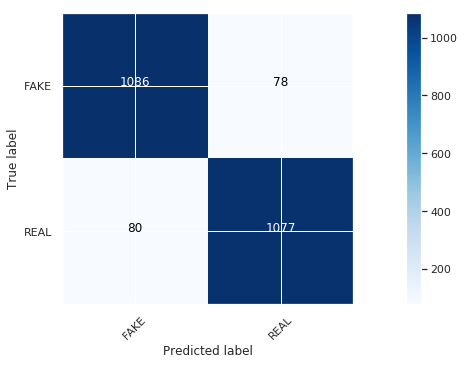

Final Accuracy
0.9319258940112021


In [254]:
print("Predicting fake news on the test set")
y_pred = max_ent_chi2_cls.predict(test_text_tfidf_ch2_features)

# Undo the label transformation to get the predictions as REAL or FAKE
y_pred = le.inverse_transform(y_pred)

print("Classification Report")
print
print(classification_report(y_test, y_pred, target_names=["FAKE", "REAL"]))
cm = confusion_matrix(y_test, y_pred, labels=["FAKE", "REAL"])
 
plot_confusion_matrix(cm, classes=["FAKE", "REAL"])


print("Final Accuracy")
print(accuracy_score(y_test, y_pred))

In [255]:
results_df.loc[len(results_df)] = ['MaxEnt', 'News Text and Title', 'POS + Dependency Parsing + TF-IDF + ChiSquared', accuracy_score(y_test, y_pred,)]
results_df

,Classification Approach,Information Source,NLP Preprocessing,Accuracy
0,Naive Bayes,News Title,Baseline Preprocessing,0.797070
1,Naive Bayes,News Text,Baseline Preprocessing,0.873330
2,Naive Bayes,News Text and Title,Baseline Preprocessing,0.888410
3,SVM,News Text and Title,Baseline Preprocessing,0.897458
4,MaxEnt,News Text and Title,Baseline Preprocessing,0.912538
5,MaxEnt,News Text and Title,POS,0.907368
6,MaxEnt,News Text and Title,POS only Nouns,0.896596
7,MaxEnt,News Text and Title,Dependency Parsing,0.647566
8,MaxEnt,News Text and Title,POS + Dependency Parsing,0.914261
9,MaxEnt,News Text and Title,POS + Dependency Parsing + TF-IDF,0.932788


We've got almost the same performance by using only 5000 features instead of the whole feature set (which inclues plus to 30000).

Therefore the smaller model (that including less features) is preferred. In this way we can avoid overfitting the training data as well as we can train the model much faster (as you could have seen).

### Bigram Count Vectorizer

Often considering Bigrams tends to really boost classification performance. In my experience Trigrams do not have offer the same boost as Bigrams, but they are worth considering and could be essential for certain types of classifiers. You could also go beyond Trigrams if you felt that the classification problem requires it.


In [256]:
bigram_count_vect = CountVectorizer(analyzer = "word", ngram_range=(1,2)) # set min_df = frequency
train_bigram_features = bigram_count_vect.fit_transform(X_train.clean_title_and_text)
test_bigram_features = bigram_count_vect.transform(X_test.clean_title_and_text)

Training model
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  7.1min finished
/home/acastellanos/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


CV-scores for each grid configuration
Accuracy: 0.917 (+/-0.029) for params: {'C': 1000, 'penalty': 'l1'}
Accuracy: 0.914 (+/-0.007) for params: {'C': 0.1, 'penalty': 'l2'}
Accuracy: 0.912 (+/-0.012) for params: {'C': 1, 'penalty': 'l2'}
Accuracy: 0.911 (+/-0.012) for params: {'C': 100, 'penalty': 'l1'}
Accuracy: 0.910 (+/-0.010) for params: {'C': 0.01, 'penalty': 'l2'}
Accuracy: 0.908 (+/-0.023) for params: {'C': 10, 'penalty': 'l1'}
Accuracy: 0.907 (+/-0.014) for params: {'C': 10, 'penalty': 'l2'}
Accuracy: 0.904 (+/-0.021) for params: {'C': 1, 'penalty': 'l1'}
Accuracy: 0.897 (+/-0.015) for params: {'C': 100, 'penalty': 'l2'}
Accuracy: 0.892 (+/-0.010) for params: {'C': 0.001, 'penalty': 'l2'}
Accuracy: 0.891 (+/-0.010) for params: {'C': 1000, 'penalty': 'l2'}
Accuracy: 0.884 (+/-0.017) for params: {'C': 0.1, 'penalty': 'l1'}
Accuracy: 0.823 (+/-0.004) for params: {'C': 0.01, 'penalty': 'l1'}
Accuracy: 0.657 (+/-0.036) for params: {'C': 0.001, 'penalty': 'l1'}

Learning curve for th

/home/acastellanos/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/acastellanos/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


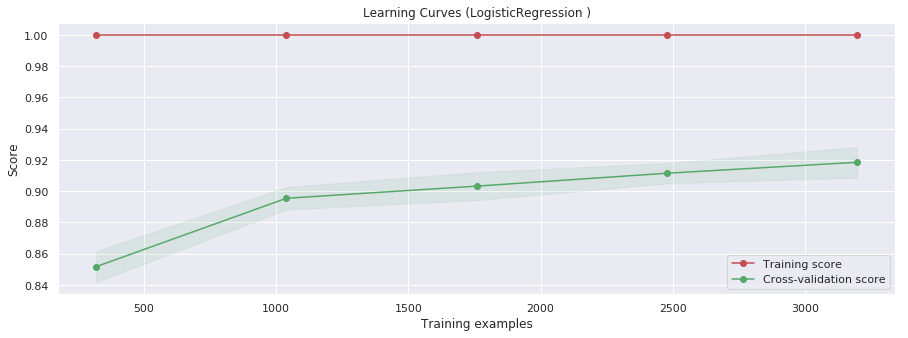

In [257]:
max_ent_bigram_cls = train_and_evaluate_classifier(train_bigram_features, encoded_y_train, LogisticRegression(), max_ent_grid)

In [258]:
print("Best estimator found by grid search:")
print(max_ent_bigram_cls.best_estimator_)

Best estimator found by grid search:
LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


Predicting fake news on the test set
Classification Report
              precision    recall  f1-score   support

        FAKE       0.93      0.94      0.93      1164
        REAL       0.94      0.93      0.93      1157

   micro avg       0.93      0.93      0.93      2321
   macro avg       0.93      0.93      0.93      2321
weighted avg       0.93      0.93      0.93      2321

Confusion matrix, without normalization


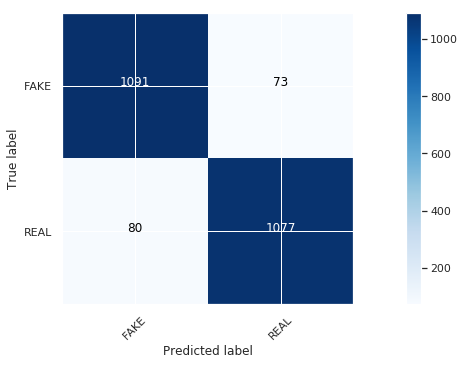

Final Accuracy
0.934080137871607


In [259]:
print("Predicting fake news on the test set")
y_pred = max_ent_bigram_cls.predict(test_bigram_features)

# Undo the label transformation to get the predictions as REAL or FAKE
y_pred = le.inverse_transform(y_pred)

print("Classification Report")
print
print(classification_report(y_test, y_pred, target_names=["FAKE", "REAL"]))
cm = confusion_matrix(y_test, y_pred, labels=["FAKE", "REAL"])
 
plot_confusion_matrix(cm, classes=["FAKE", "REAL"])


print("Final Accuracy")
print(accuracy_score(y_test, y_pred))

In [260]:
results_df.loc[len(results_df)] = ['MaxEnt', 'News Text and Title', 'Bigram', accuracy_score(y_test, y_pred,)]
results_df

,Classification Approach,Information Source,NLP Preprocessing,Accuracy
0,Naive Bayes,News Title,Baseline Preprocessing,0.797070
1,Naive Bayes,News Text,Baseline Preprocessing,0.873330
2,Naive Bayes,News Text and Title,Baseline Preprocessing,0.888410
3,SVM,News Text and Title,Baseline Preprocessing,0.897458
4,MaxEnt,News Text and Title,Baseline Preprocessing,0.912538
5,MaxEnt,News Text and Title,POS,0.907368
6,MaxEnt,News Text and Title,POS only Nouns,0.896596
7,MaxEnt,News Text and Title,Dependency Parsing,0.647566
8,MaxEnt,News Text and Title,POS + Dependency Parsing,0.914261
9,MaxEnt,News Text and Title,POS + Dependency Parsing + TF-IDF,0.932788


**Bigram increases the performance of UNIGRAM models (from MaxEnt - News Text and Title - Baseline Preprocessing: aprox. 91% of accuracy to 93.4%).** 

We have used a simple TF approach, let's now create a final model using bigrams and a TF-IDF scoring.

In [261]:
tfidf = TfidfTransformer(norm="l2")
train_text_bigram_tfidf_features = tfidf.fit_transform(train_bigram_features)
test_text_bigram_tfidf_features = tfidf.fit_transform(test_bigram_features)    

Training model
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  2.1min finished


CV-scores for each grid configuration
Accuracy: 0.925 (+/-0.019) for params: {'C': 1000, 'penalty': 'l1'}
Accuracy: 0.924 (+/-0.014) for params: {'C': 100, 'penalty': 'l1'}
Accuracy: 0.923 (+/-0.022) for params: {'C': 10, 'penalty': 'l1'}
Accuracy: 0.919 (+/-0.012) for params: {'C': 1000, 'penalty': 'l2'}
Accuracy: 0.917 (+/-0.014) for params: {'C': 100, 'penalty': 'l2'}
Accuracy: 0.911 (+/-0.017) for params: {'C': 10, 'penalty': 'l2'}
Accuracy: 0.890 (+/-0.016) for params: {'C': 1, 'penalty': 'l2'}
Accuracy: 0.855 (+/-0.013) for params: {'C': 1, 'penalty': 'l1'}
Accuracy: 0.852 (+/-0.022) for params: {'C': 0.1, 'penalty': 'l2'}
Accuracy: 0.812 (+/-0.101) for params: {'C': 0.01, 'penalty': 'l2'}
Accuracy: 0.740 (+/-0.011) for params: {'C': 0.1, 'penalty': 'l1'}
Accuracy: 0.509 (+/-0.020) for params: {'C': 0.001, 'penalty': 'l1'}
Accuracy: 0.509 (+/-0.020) for params: {'C': 0.01, 'penalty': 'l1'}
Accuracy: 0.497 (+/-0.041) for params: {'C': 0.001, 'penalty': 'l2'}

Learning curve for th

/home/acastellanos/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/acastellanos/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


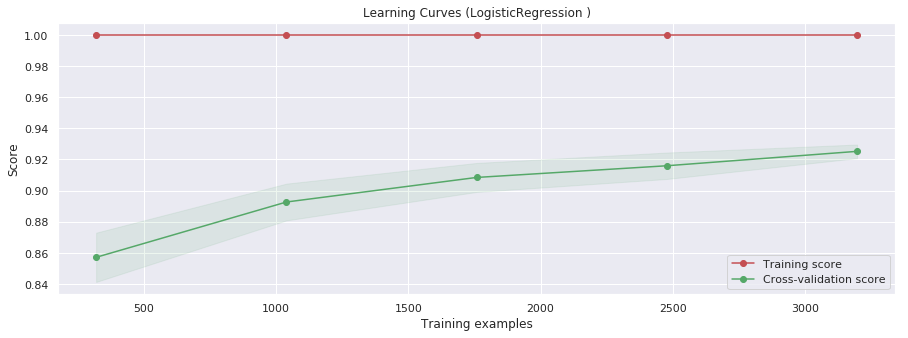

In [262]:
max_ent_tfidf_bigram_cls = train_and_evaluate_classifier(train_text_bigram_tfidf_features, encoded_y_train, LogisticRegression(), max_ent_grid)

In [263]:
print("Best estimator found by grid search:")
print(max_ent_tfidf_bigram_cls.best_estimator_)

Best estimator found by grid search:
LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


Predicting fake news on the test set
Classification Report
              precision    recall  f1-score   support

        FAKE       0.94      0.93      0.94      1164
        REAL       0.93      0.94      0.94      1157

   micro avg       0.94      0.94      0.94      2321
   macro avg       0.94      0.94      0.94      2321
weighted avg       0.94      0.94      0.94      2321

Confusion matrix, without normalization


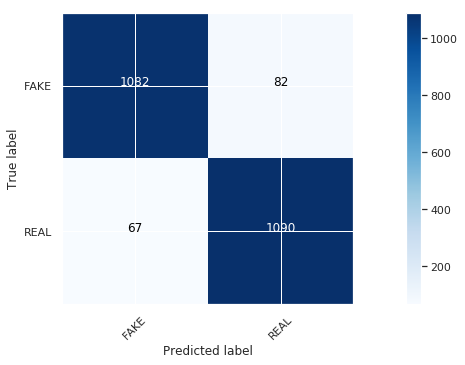

Final Accuracy
0.935803532959931


In [264]:
print("Predicting fake news on the test set")
y_pred = max_ent_tfidf_bigram_cls.predict(test_text_bigram_tfidf_features)

# Undo the label transformation to get the predictions as REAL or FAKE
y_pred = le.inverse_transform(y_pred)

print("Classification Report")
print
print(classification_report(y_test, y_pred, target_names=["FAKE", "REAL"]))
cm = confusion_matrix(y_test, y_pred, labels=["FAKE", "REAL"])
 
plot_confusion_matrix(cm, classes=["FAKE", "REAL"])


print("Final Accuracy")
print(accuracy_score(y_test, y_pred))

In [265]:
results_df.loc[len(results_df)] = ['MaxEnt', 'News Text and Title', 'Bigram + TF-IDF', accuracy_score(y_test, y_pred,)]
results_df

,Classification Approach,Information Source,NLP Preprocessing,Accuracy
0,Naive Bayes,News Title,Baseline Preprocessing,0.797070
1,Naive Bayes,News Text,Baseline Preprocessing,0.873330
2,Naive Bayes,News Text and Title,Baseline Preprocessing,0.888410
3,SVM,News Text and Title,Baseline Preprocessing,0.897458
4,MaxEnt,News Text and Title,Baseline Preprocessing,0.912538
5,MaxEnt,News Text and Title,POS,0.907368
6,MaxEnt,News Text and Title,POS only Nouns,0.896596
7,MaxEnt,News Text and Title,Dependency Parsing,0.647566
8,MaxEnt,News Text and Title,POS + Dependency Parsing,0.914261
9,MaxEnt,News Text and Title,POS + Dependency Parsing + TF-IDF,0.932788


The model including all the improvements (TF-IDF + BIGRAMS) offers the best performance (as expected): around 94%

In [266]:
def most_informative_feature_for_binary_classification(vectorizer, classifier, n=100):
    """
    See: https://stackoverflow.com/a/26980472
    
    Identify most important features if given a vectorizer and binary classifier. Set n to the number
    of weighted features you would like to show. (Note: current implementation merely prints and does not 
    return top classes.)
    """

    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    topn_class1 = sorted(zip(feature_names, classifier.coef_[0]), key=lambda u: u[1])[:n]
    topn_class2 = sorted(zip(feature_names, classifier.coef_[0]), key=lambda u: -u[1])[:n]

    return topn_class1, topn_class2



In [267]:
fake_features, real_features = most_informative_feature_for_binary_classification(bigram_count_vect, max_ent_cls.best_estimator_, n=30)

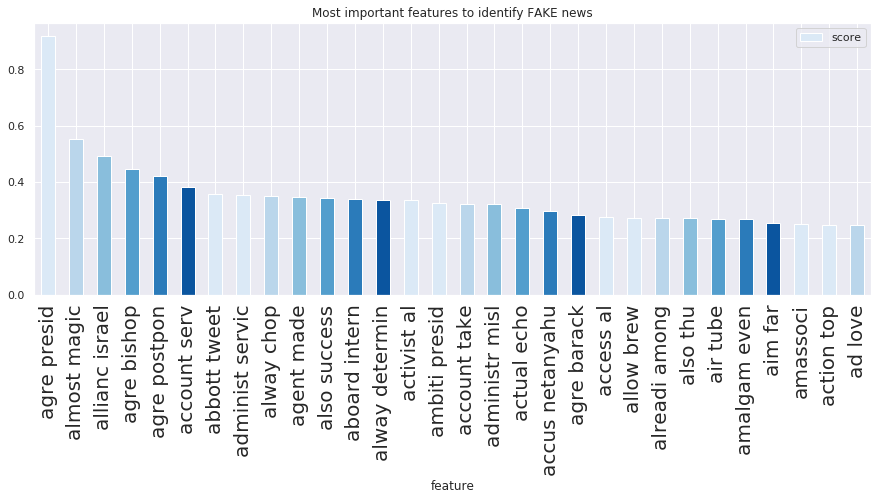

In [268]:
top_fake_features = pandas.DataFrame(fake_features, columns=["feature", "score"])
top_fake_features.score = abs(top_fake_features.score)
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
top_fake_features.plot(x="feature", y="score", kind="bar", title="Most important features to identify FAKE news")

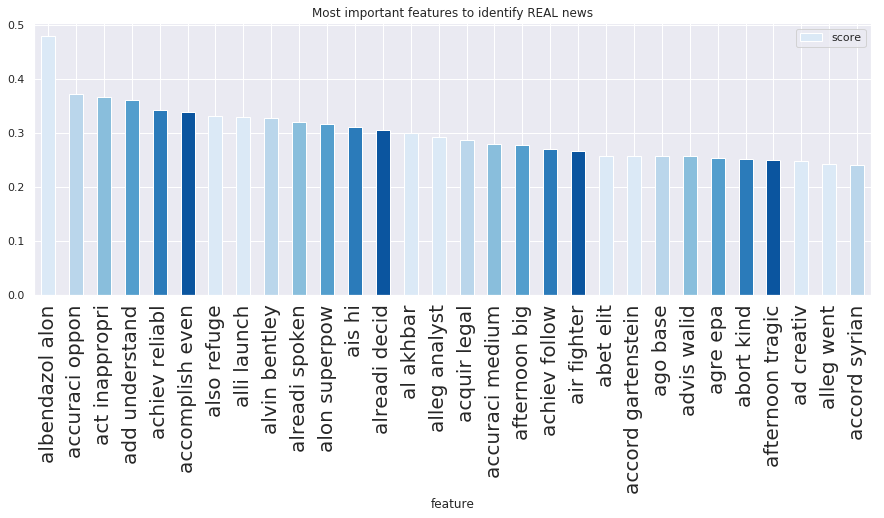

In [269]:
top_real_features = pandas.DataFrame(real_features, columns=["feature", "score"])
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
top_real_features.plot(x="feature", y="score", kind="bar", title="Most important features to identify REAL news")

### Trigram Count Vectorizer

Impact of trigrams

In [270]:
trigram_count_vect = CountVectorizer(analyzer = "word", ngram_range=(1,3)) # set min_df = frequency
train_trigram_features = trigram_count_vect.fit_transform(X_train.clean_text)
test_trigram_features = trigram_count_vect.transform(X_test.clean_text)

In [271]:
tfidf = TfidfTransformer(norm="l2")
train_text_trigram_tfidf_features = tfidf.fit_transform(train_trigram_features)
test_text_trigram_tfidf_features = tfidf.fit_transform(test_trigram_features)   

Training model
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  5.2min finished


CV-scores for each grid configuration
Accuracy: 0.925 (+/-0.010) for params: {'C': 100, 'penalty': 'l1'}
Accuracy: 0.924 (+/-0.013) for params: {'C': 1000, 'penalty': 'l1'}
Accuracy: 0.919 (+/-0.016) for params: {'C': 10, 'penalty': 'l1'}
Accuracy: 0.905 (+/-0.018) for params: {'C': 1000, 'penalty': 'l2'}
Accuracy: 0.905 (+/-0.019) for params: {'C': 100, 'penalty': 'l2'}
Accuracy: 0.902 (+/-0.019) for params: {'C': 10, 'penalty': 'l2'}
Accuracy: 0.886 (+/-0.020) for params: {'C': 1, 'penalty': 'l2'}
Accuracy: 0.850 (+/-0.017) for params: {'C': 0.1, 'penalty': 'l2'}
Accuracy: 0.842 (+/-0.015) for params: {'C': 1, 'penalty': 'l1'}
Accuracy: 0.752 (+/-0.249) for params: {'C': 0.01, 'penalty': 'l2'}
Accuracy: 0.704 (+/-0.033) for params: {'C': 0.1, 'penalty': 'l1'}
Accuracy: 0.509 (+/-0.020) for params: {'C': 0.001, 'penalty': 'l1'}
Accuracy: 0.509 (+/-0.020) for params: {'C': 0.01, 'penalty': 'l1'}
Accuracy: 0.492 (+/-0.024) for params: {'C': 0.001, 'penalty': 'l2'}

Learning curve for th

/home/acastellanos/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/acastellanos/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


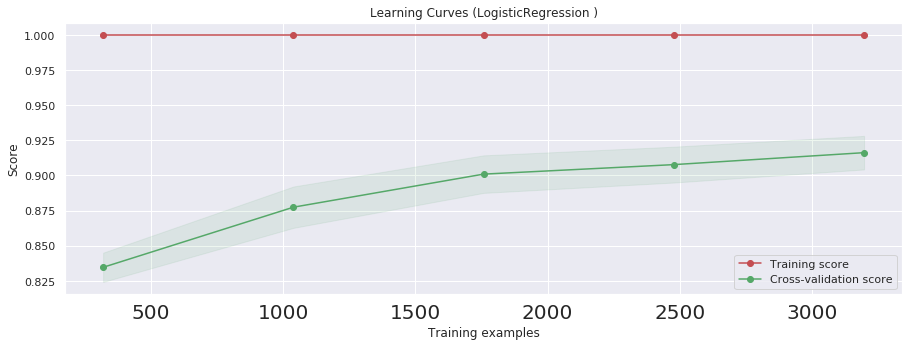

In [277]:
max_ent_tfidf_trigram_cls = train_and_evaluate_classifier(train_text_trigram_tfidf_features, encoded_y_train, LogisticRegression(), max_ent_grid)

In [278]:
print("Best estimator found by grid search:")
print(max_ent_tfidf_trigram_cls.best_estimator_)

Best estimator found by grid search:
LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


Predicting fake news on the test set
Classification Report
              precision    recall  f1-score   support

        FAKE       0.95      0.89      0.92      1164
        REAL       0.89      0.95      0.92      1157

   micro avg       0.92      0.92      0.92      2321
   macro avg       0.92      0.92      0.92      2321
weighted avg       0.92      0.92      0.92      2321

Confusion matrix, without normalization


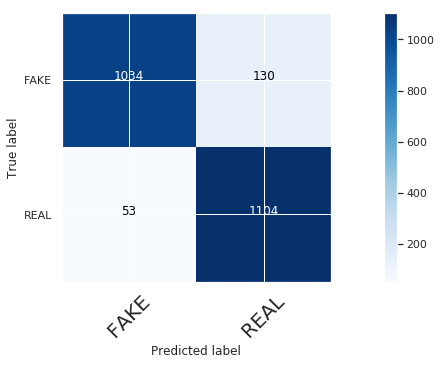

Final Accuracy
0.9211546747091771


In [279]:
print("Predicting fake news on the test set")
y_pred = max_ent_tfidf_trigram_cls.predict(test_text_trigram_tfidf_features)

# Undo the label transformation to get the predictions as REAL or FAKE
y_pred = le.inverse_transform(y_pred)

print("Classification Report")
print
print(classification_report(y_test, y_pred, target_names=["FAKE", "REAL"]))
cm = confusion_matrix(y_test, y_pred, labels=["FAKE", "REAL"])
 
plot_confusion_matrix(cm, classes=["FAKE", "REAL"])

print("Final Accuracy")
print(accuracy_score(y_test, y_pred))

In [280]:
results_df.loc[len(results_df)] = ['MaxEnt', 'News Text and Title', 'Trigram + TF-IDF', accuracy_score(y_test, y_pred,)]
results_df

,Classification Approach,Information Source,NLP Preprocessing,Accuracy
0,Naive Bayes,News Title,Baseline Preprocessing,0.797070
1,Naive Bayes,News Text,Baseline Preprocessing,0.873330
2,Naive Bayes,News Text and Title,Baseline Preprocessing,0.888410
3,SVM,News Text and Title,Baseline Preprocessing,0.897458
4,MaxEnt,News Text and Title,Baseline Preprocessing,0.912538
5,MaxEnt,News Text and Title,POS,0.907368
6,MaxEnt,News Text and Title,POS only Nouns,0.896596
7,MaxEnt,News Text and Title,Dependency Parsing,0.647566
8,MaxEnt,News Text and Title,POS + Dependency Parsing,0.914261
9,MaxEnt,News Text and Title,POS + Dependency Parsing + TF-IDF,0.932788


Performance is lower. In order to justify the application of trigrams, let's take a look to the most informative features to check if there are some interesting trigrams among them.

In [281]:
fake_features, real_features = most_informative_feature_for_binary_classification(trigram_count_vect, max_ent_cls.best_estimator_, n=50)

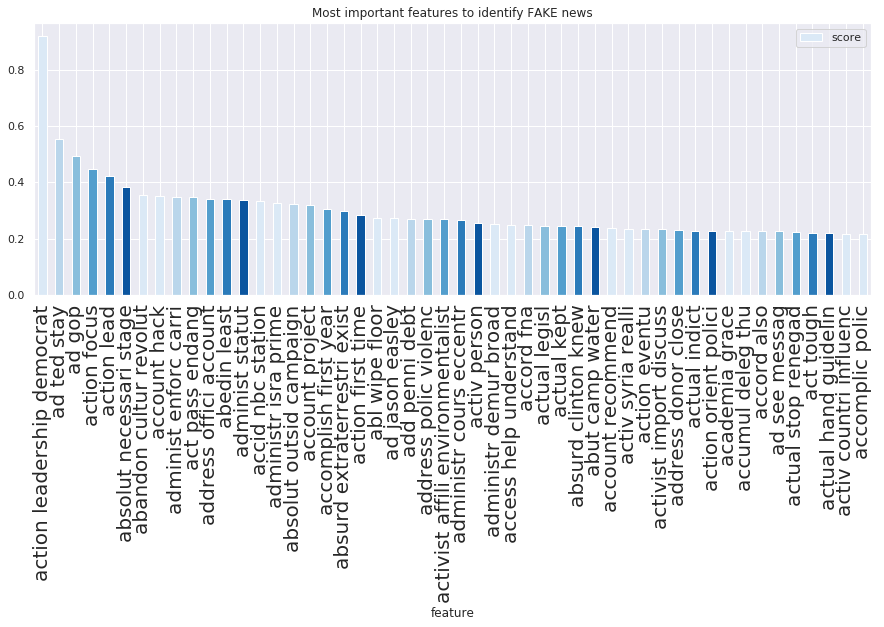

In [282]:
top_fake_features = pandas.DataFrame(fake_features, columns=["feature", "score"])
top_fake_features.score = abs(top_fake_features.score)
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
top_fake_features.plot(x="feature", y="score", kind="bar", title="Most important features to identify FAKE news")

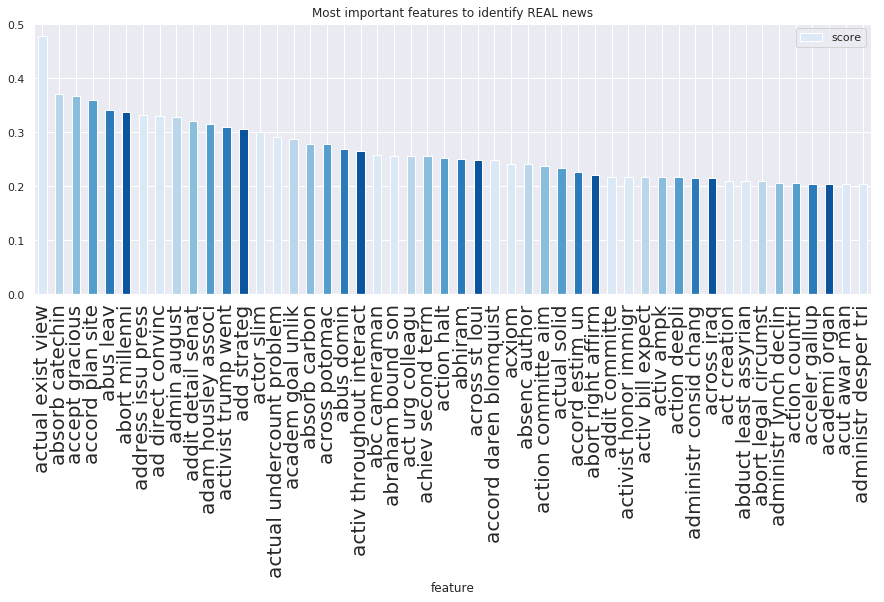

In [283]:
top_real_features = pandas.DataFrame(real_features, columns=["feature", "score"])
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
top_real_features.plot(x="feature", y="score", kind="bar", title="Most important features to identify REAL news")

There are not so much trigrams between the most informative class features.

It seems that trigrams does not have a large impact in the classification, so we can safely decide to not use them and stick to bigrams.


## Final model

Based on the previous examples, we create our final model using TF-IDF, bigrams and select the best features according to the Chi-Squared weight to create a Maximum Entropy Classifier.

In [284]:
max_ent_tfidf_bigram_cls

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=0, test_size=0.2, train_size=None),
       error_score=0.0,
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=5)

Predicting fake news on the test set
Classification Report
              precision    recall  f1-score   support

        FAKE       0.94      0.93      0.94      1164
        REAL       0.93      0.94      0.94      1157

   micro avg       0.94      0.94      0.94      2321
   macro avg       0.94      0.94      0.94      2321
weighted avg       0.94      0.94      0.94      2321

Confusion matrix, without normalization


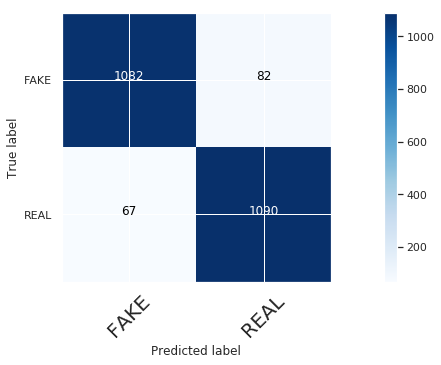

Final Accuracy
0.935803532959931


In [285]:
print("Predicting fake news on the test set")
y_pred = max_ent_tfidf_bigram_cls.predict(test_text_bigram_tfidf_features)

# Undo the label transformation to get the predictions as REAL or FAKE
y_pred = le.inverse_transform(y_pred)

print("Classification Report")
print
print(classification_report(y_test, y_pred, target_names=["FAKE", "REAL"]))
cm = confusion_matrix(y_test, y_pred, labels=["FAKE", "REAL"])
 
plot_confusion_matrix(cm, classes=["FAKE", "REAL"])

print("Final Accuracy")
print(accuracy_score(y_test, y_pred))

# Conclusion

We have addressed a text classification problem based on detecting FAKE news among a dataset of real news reports.

After inspecting the dataset to make sense of the data, we have experimented with the application of different NLP procedures for the optimization of our models. In particular:
 - **Stopwords:** After checking the most frequent words of each class, there were mainly stopwords. Therefore we used an English stopwords to remove them since they are not going to help our models to identify the classes.
 - **Normalization:** There were also many different formulations of the same work among the most frequent features (be, am, was). To normalize these different formulations of the same term, we have applied a lemmatization + stemming strategy. This processing reduces the dimensionality of the document term matrix, as well as it would find new relationships between the data (based on the normalized terms).

There were **two kinds of textual data** to fit our models: the text and the headline of the news reports. It was the text in the news reports which created the more accurate models. That is obvious, in the end, we have much more information in the news report itself than in the text.

With the data processed already processed, we implemented our **first baseline models**. In more detail, an own-implemented version of Naive Bayes, SVM and a MaxEnt model. We have made use of the tools that sklearn provides to cross-validate, optimize and evaluate the models
As expected, it was SVM, and especially Maximum Entropy models which offered the best performance for the task. You can test some other models (e.g. SGD Classifier + Perceptron or Passive-Aggressive) that may further improve the final performance

We then addressed other NLP techniques to improve the classification performance.
 - **Use POS and DepParsing**: This methodologies extend the textual information on the dataset. In this situation it does not provide many more information to that already contained in the data. However, it is useful to create "smaller" representations (e.g. only based on nouns) which do not provide the best performance but could be useful for production scenarios.  
 - **Use TF-IDF**: For our first baseline models we created the document-term matrix using the word-count. As seen in class, frequency-based representations are sometimes not enough to properly represent the importance of the terms in the documents. Therefore, we create new MaxEnt models based on a TF-IDF representation.
 - **Feature Selection**: The original dataset contained more than 30.000 terms (even after stopword removal and normalization). To reduce the dimensionality and focus only on the most important terms, the best features (according to their Chi-Squared weighting) were selected. The performance of the model using this reduced dataset was similar to that of the model including the whole set of terms.
 - **BiGram and TriGrams**: The baseline models were based on unigrams. While there might be unigrams highly relevant to detect the classes, n-grams can capture more meaning (e.g., detect entities such as Hillary Clinton, capture negations, capture object-action relationships, ...). Using the TF-IDF weighting, we have created a bigram and trigram representation and fit with them new MaxEnt models.
 

Best results have been achieved by MaxEnt n-gram models applying a TF-IDF weighting, offering a performance around 92-94% of accuracy. Almost perfect classification. We are not going to be fooled anymore by fake news.


# Deep Learning

Deep Learning was out of the scope of this assignment; however, I wanted to include an usage examples as an additional solution.

I have created a solution based on Bi-Directional LSTMs. LSTMs are designed to take into account sequential information, which make them especially suitable for dealing with texts. Bi-Directional architectures allow to capture relationships that are before and after a given pivot in the sentence. Hence, they are able to model the whole set of linguistic relationships in the sentences.

In order to facilitate the model creation, I will make use of [Keras](https://keras.io/) a high-level API for neural networks.

In [41]:
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional
from keras.models import Sequential, Model, Input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.initializers import Constant


Using TensorFlow backend.


Definition of the initial hyper-parameters for the network. This step is susceptible to be improved by creating a procedure to find the best combination of them. Take a look to the [Hyperopt library](https://github.com/maxpumperla/hyperas)

In [42]:
epochs = 50
emb_dim = 128
batch_size = 32
n_most_common_words = 50000
max_len = 130


In order to feed the training data to the network, we need to reformat the input data as a sequence of tokens.

To that end, I will use the functions provided by Keras. Firstly, I use the `text_to_sequences` function in the  `Tokenizer` class to convert the raw text to sequences of tokens 

In [43]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train.clean_text)
sequences_train = tokenizer.texts_to_sequences(X_train.clean_text)
sequences_test = tokenizer.texts_to_sequences(X_test.clean_text)

One problem with this format is that each sentence has its own length. However, the LSTM requires all the inputs to have the same size. To solve this issue I will use the `pad_sequences` function to pad the sentences and format all of them to the same size.

In [44]:
train_text_lstm = pad_sequences(sequences_train, maxlen=max_len)
test_text_lstm = pad_sequences(sequences_test, maxlen=max_len)

Y_train = to_categorical(encoded_y_train, 2)
Y_test = to_categorical(le.transform(y_test.values), 2)

We have to create the DL model. Our model will include:

- Embedding Layer: Instead of using the original tokens we will create a dense representation (similar to word2vec) of the input
- Bidirectional LSTM: Two LSTMs (forward and backward) to model the sequences
- Dense Layer: The final classifier that operates over the representation provided by the Bi-LSTM to decide to which class the input belongs

In [64]:
model = Sequential()
model.add(Embedding(n_most_common_words, emb_dim, input_length=train_text_lstm.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(32,dropout=0.2,recurrent_dropout=0.2)))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 130, 128)          6400000   
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 130, 128)          0         
_________________________________________________________________
bidirectional_9 (Bidirection (None, 130, 128)          98816     
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 64)                41216     
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 130       
Total params: 6,540,162
Trainable params: 6,540,162
Non-trainable params: 0
_________________________________________________________________
None


In [65]:
history = model.fit(train_text_lstm, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_acc',patience=5, min_delta=0.01)])

Train on 3197 samples, validate on 800 samples
Epoch 1/50
3197/3197 [==============================] - 51s 16ms/step - loss: 0.4726 - acc: 0.7654 - val_loss: 0.3058 - val_acc: 0.8750
Epoch 2/50
3197/3197 [==============================] - 42s 13ms/step - loss: 0.1492 - acc: 0.9462 - val_loss: 0.3065 - val_acc: 0.8862
Epoch 3/50
3197/3197 [==============================] - 54s 17ms/step - loss: 0.0481 - acc: 0.9837 - val_loss: 0.4350 - val_acc: 0.8750
Epoch 4/50
3197/3197 [==============================] - 47s 15ms/step - loss: 0.0198 - acc: 0.9950 - val_loss: 0.4820 - val_acc: 0.8812
Epoch 5/50
3197/3197 [==============================] - 40s 13ms/step - loss: 0.0037 - acc: 0.9987 - val_loss: 0.5559 - val_acc: 0.8800
Epoch 6/50
3197/3197 [==============================] - 38s 12ms/step - loss: 0.0018 - acc: 0.9997 - val_loss: 0.6474 - val_acc: 0.8788
Epoch 7/50
3197/3197 [==============================] - 39s 12ms/step - loss: 0.0011 - acc: 0.9997 - val_loss: 0.7275 - val_acc: 0.8738


Classification Report
              precision    recall  f1-score   support

        FAKE       0.88      0.85      0.86      1164
        REAL       0.86      0.88      0.87      1157

   micro avg       0.87      0.87      0.87      2321
   macro avg       0.87      0.87      0.87      2321
weighted avg       0.87      0.87      0.87      2321

Confusion matrix, without normalization


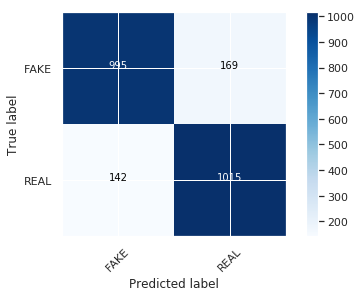

Final Accuracy
0.8660060318828091


In [66]:
y_pred = model.predict_classes(test_text_lstm)

# Undo the label transformation to get the predictions as REAL or FAKE
y_pred = le.inverse_transform(y_pred)

print("Classification Report")
print
print(classification_report(y_test, y_pred, target_names=["FAKE", "REAL"]))
cm = confusion_matrix(y_test, y_pred, labels=["FAKE", "REAL"])
 
plot_confusion_matrix(cm, classes=["FAKE", "REAL"])

print("Final Accuracy")
print(accuracy_score(y_test, y_pred))

## Pre-trained Embeddings

In the previous approach we tried to learn the Embedding representation from our training data.
It is only recommendable when you have enough data to learn the embedding. However, the dataset that we are using for this assignment is not large enough.

For this situations, it is preferable to use pre-trained embeddings. I will make use of [Glove](https://nlp.stanford.edu/projects/glove/) embeddings. 

After you download the embeddings (refer to the Glove webpage), we open them and create a matrix where for each word (row) we have its embedding (vector) representation.

In [49]:
import os 

embeddings_index = {}
f = open(os.path.join('..', 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [50]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 35701 unique tokens.


In [51]:
num_words = min(n_most_common_words, len(word_index)) + 1
print(num_words)

embedding_dim = 100


embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i > n_most_common_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # we found the word - add that words vector to the matrix
        embedding_matrix[i] = embedding_vector
    else:
        # doesn't exist, assign a random vector
        embedding_matrix[i] = np.random.randn(embedding_dim)

35702


We need to modify the Embedding layer to accomodate the Glove Embeddings

In [61]:
model = Sequential()
model.add(Embedding(n_most_common_words,
                    emb_dim,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=train_text_lstm.shape[1],
                    trainable=True))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(32,dropout=0.2,recurrent_dropout=0.2)))
model.add(Dense(2, activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 130, 128)          6400000   
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 130, 128)          0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 130, 128)          98816     
_________________________________________________________________
bidirectional_8 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 130       
Total params: 6,540,162
Trainable params: 6,540,162
Non-trainable params: 0
_________________________________________________________________
None


In [62]:
history = model.fit(train_text_lstm, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_acc',patience=5, min_delta=0.01)])

Train on 3197 samples, validate on 800 samples
Epoch 1/50
3197/3197 [==============================] - 51s 16ms/step - loss: 0.6029 - acc: 0.6691 - val_loss: 0.4757 - val_acc: 0.7712
Epoch 2/50
3197/3197 [==============================] - 39s 12ms/step - loss: 0.3818 - acc: 0.8333 - val_loss: 0.4109 - val_acc: 0.8200
Epoch 3/50
3197/3197 [==============================] - 39s 12ms/step - loss: 0.2360 - acc: 0.9037 - val_loss: 0.4141 - val_acc: 0.8300
Epoch 4/50
3197/3197 [==============================] - 39s 12ms/step - loss: 0.1403 - acc: 0.9506 - val_loss: 0.4470 - val_acc: 0.8550
Epoch 5/50
3197/3197 [==============================] - 38s 12ms/step - loss: 0.0919 - acc: 0.9656 - val_loss: 0.5155 - val_acc: 0.8450
Epoch 6/50
3197/3197 [==============================] - 39s 12ms/step - loss: 0.0541 - acc: 0.9834 - val_loss: 0.5549 - val_acc: 0.8538
Epoch 7/50
3197/3197 [==============================] - 38s 12ms/step - loss: 0.0438 - acc: 0.9847 - val_loss: 0.5866 - val_acc: 0.8512
E

Classification Report
              precision    recall  f1-score   support

        FAKE       0.90      0.79      0.84      1164
        REAL       0.81      0.92      0.86      1157

   micro avg       0.85      0.85      0.85      2321
   macro avg       0.86      0.85      0.85      2321
weighted avg       0.86      0.85      0.85      2321

Confusion matrix, without normalization


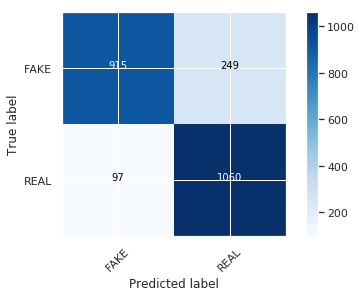

Final Accuracy
0.8509263248599741


In [63]:
y_pred = model.predict_classes(test_text_lstm)

# Undo the label transformation to get the predictions as REAL or FAKE
y_pred = le.inverse_transform(y_pred)

print("Classification Report")
print
print(classification_report(y_test, y_pred, target_names=["FAKE", "REAL"]))
cm = confusion_matrix(y_test, y_pred, labels=["FAKE", "REAL"])
 
plot_confusion_matrix(cm, classes=["FAKE", "REAL"])

print("Final Accuracy")
print(accuracy_score(y_test, y_pred))

Neither pre-trained nor learned embeddings seems to be able to improve the performance of simpler classifiers (SVM, MaxEnt). The main reason is that we do not have enough data to train these complex DL-based representations

## Pre-trained Models (FastText)

In the previous approach we use pre-train embeddings (representations of words). But, we can also make use of pre-trained classifiers: complex Deep Learning models trained over huge datasets that allow them to learn the language-dependent relationships (i.e., they learn to "speak English") that can be later adapted to a particular task (our classification problem).

[Facebook's Fast Text](https://fasttext.cc/) provides some of these models. Let's use them.

In [44]:
import fastText
from fastText import train_supervised

In order to use fastText, we have to format the data to comply with the fastText input format (`__label__XXX Textual Content`, where XXX is the actual label of the instance).

In [24]:
y_train_fast_text_formatted = y_train.label.apply(lambda x: "__label__" + x)
training_data_df = pd.concat([y_train_fast_text_formatted, X_train.clean_title_and_text], axis = 1)
train_data = training_data_df[['label','clean_title_and_text']].apply(lambda x: ' '.join(x.apply(lambda x: np.str_(x))), axis=1)

with open("train_data.txt",'w') as outfile:
    train_data.to_string(outfile, index=False)

In [25]:
y_test_fast_text_formatted = y_test.apply(lambda x: "__label__" + x)
test_data_df = pd.concat([y_test_fast_text_formatted, X_test.clean_title_and_text], axis = 1)
test_data = test_data_df[['label','clean_title_and_text']].apply(lambda x: ' '.join(x.apply(lambda x: np.str_(x))), axis=1)

with open("test_data.txt",'w') as outfile:
    test_data.to_string(outfile, index=False)

We now train the model and evaluate over the test set


In [59]:
model = train_supervised(
    input="train_data.txt", epoch=100, lr=0.1, wordNgrams=5, verbose=2, minCount=1, loss="softmax"
)

In [60]:
def print_results(N, p, r):
    print("N\t" + str(N))
    print("Precision@{}\t{:.3f}".format(1, p))
    print("Recall@{}\t{:.3f}".format(1, r))
    

print_results(*model.test("test_data.txt"))

N	2321
Precision@1	0.782
Recall@1	0.782


Neither precision nor recall are able to achieve the levels of simpler classifiers.

None of the DL approaches seem to outperform the MaxEnt or SVM classifiers. It can be due to:

- We do not have enough data to train these complex architectures.
- We have not included the linguistic information that we have used in the previous methodologies.
- We have not optimized the hyperparameters of the DL architectures. 

If you want to play with these ideas, I recommend you to start with the last two points.